# CI7520 –Assignment 2: Machine Learning with Deep Neural Networks

# Medical Image Analysis and Classification using DermaMNIST and RetinaMNIST

by 

Adrian Bandy (K2132274)

Shashwat Bhardwaj (K2149137)

Royce Daran Shakespeare (K2046699)

Padmesh Upadhyay (K2136572)




#1) Introduction

In this assignment we will be reviewing skin and retina photos from the medMNIST and dermaMNIST datasets (found at https://medmnist.com/) 

Our task is to create and test convolutional neural networks (CNNs) to model and predict these images and their respective classes. We will also employ existing CNN and compare performances.

In [1]:
#Import required libraries

#data manipulation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen

#deep learning modules and layers
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
import keras.layers as layers
from keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D,Dropout,Lambda,BatchNormalization 
from keras.backend import set_image_data_format
from keras import Model
from keras import Input
from tensorflow.keras.optimizers import Adam

# Optimizers
from keras import optimizers
from keras import regularizers

# visualisation tools from sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Transfer Learning Models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16


# Synthetic Image Generation (and oversampling) to reduce effect of class imbalance.
from sklearn.svm import LinearSVC
from sklearn.utils import compute_class_weight
from sklearn.utils import compute_sample_weight
from keras.utils.np_utils import to_categorical

#Early stopping callback
val_loss_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 50)
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential

## 1.1) Predefined Functions

In [2]:
def plot_from_generator(generator, generator_name:str, num_of_images:int):
  '''
  Accepts an image generator, a given name and number of images to generate.
  Will plot images in rows of 5.
  '''
  images, target = next(generator)[:num_of_images]
  num_of_rows = int((num_of_images / 5) + 0.9)
  #plots 5 columns (one for each colour layer) and num_of_rows for number of rows
  fig, axes = plt.subplots(num_of_rows, 5, figsize = (7, (7*num_of_rows)))
  for plot_number, [image, target, axes] in enumerate(zip(images, target, axes)):
    axes.imshow(image)
    axes.set_xlabel(f"Label:{target}")
  print(f"\nImages from {generator_name}")
  plt.tight_layout()
  plt.show()

In [3]:
def model_creator(data_source, list_of_layers, name = '', data_augmentation = 'none', optimizer = 'adam', metrics = ['accuracy']):
  '''
  data_source = 'retina' or 'derma' for the respective retinaMNIST and dermaMNIST datasets.

  Accepts a data_augmentation set of layers.

  Accepts layer list like 
  [['conv', 'filter_number'] , 
  ['pool', 'pool_square_height'],
  ['dropout' , 0.2]
  ['nopaddingpool', pool_square_height] #will reduce dimensions#
   ['flatten',], 
   ['dense', 'neuron_size']], 

   for instance [['conv', '32'] , ['pool', '2'], ['nopaddingpool', pool_square_height],
   ['dropout' , 0.2], ['flatten'], ['dense', '7']]

   with options for optimiser and metric
   
   (input will be fixed at 28,28,3)
   (output 5 for retina, 7 for derma)

   Returns a compliled model and returns a summary of the model.
  '''
  
  model = keras.Sequential(name = name)
  model.add(keras.Input(shape= (28,28,3)))
  if data_augmentation != 'none':
    for augmentation_layer in data_augmentation:
      model.add(augmentation_layer)
  for layer in list_of_layers:
    if layer[0] == 'conv':
      model.add(layers.Conv2D(filters = layer[1], kernel_size = (layer[2], layer[2]), strides= (1,1),
                              padding = 'same', activation = 'relu'))
    elif layer[0] == 'pool':
      model.add(layers.MaxPooling2D(pool_size = (layer[1],layer[1]), padding = 'same'))
    elif layer[0] == 'nopaddingpool':
      model.add(layers.MaxPooling2D(pool_size = (layer[1],layer[1]), padding = 'valid'))
    elif layer[0] == 'dropout':
      model.add(layers.Dropout(layer[1]))
    elif layer[0] == 'flatten':
      model.add(layers.Flatten())
    elif layer[0] == 'dense':

      #check to see if neuron size is smaller than output neurons - not advised.
      if np.all([data_source == 'retina', int(layer[1]) < 5]):
        print("\nWARNING DENSE LAYER SMALLER THAN OUTPUT!!!\n")
      elif np.all([data_source == 'derma', int(layer[1]) < 7]):
        print("\nWARNING DENSE LAYER SMALLER THAN OUTPUT!!!\n")
      model.add(layers.Dense(layer[1], activation = 'relu'))

  if data_source == 'retina':
    #5 labels in retina so output is 5 neurons
    model.add(layers.Dense(5, activation = 'softmax'))
  elif data_source == 'derma':
    #7 labels in derma so output is 7 neurons
    model.add(layers.Dense(7, activation = 'softmax'))
  
  #compile model
  model.compile(optimizer = optimizer,
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = metrics)
  #print summary and return model
  print(model.summary())
  return model

In [4]:
def plot_history(history, epochs, text_vertical_adjustment = 0.00, text_horizontal_adjustment = 0.01, title = ''):
  '''
  Accepts a models history and its number of epochs ran
  Has adjustments for text for when it overlaps with curves
  Plots the validation accuracy and training accuracy
  Plots the validation loss and training loss
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize = (10,10))
  plt.subplot(1,2,1)
  plt.plot(range(epochs), acc, label = 'Train Accuracy')
  plt.plot(range(epochs), val_acc, label = 'Validation Accuracy')
  plt.axhline(y= np.amax(val_acc), linestyle = 'dashed', color = '#ff7f0e')
  plt.text(x = np.argmax(val_acc) + text_horizontal_adjustment, y = np.amax(val_acc) + text_vertical_adjustment, s = f"Max Val Accuracy:{np.amax(val_acc):.3f}\n after {np.argmax(val_acc)} epochs", color = '#ff7f0e')
  plt.xlabel('Epochs')
  plt.legend()
  plt.title('Accuracy')
  plt.suptitle(t = title)
  plt.subplot(1,2,2)
  plt.plot(range(epochs), loss, label = 'Train Loss')
  plt.plot(range(epochs), val_loss, label = 'Validation Loss')
  plt.legend()

In [5]:
#note reusing function used in our same group coursework for machine learning,
# may flag as plagiarism because of this
def plot_confusion_matrix(y_true, y_pred):    
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.show()

In [6]:
def create_alexnet(output_class):
  '''
  The following code for Alexnet implementation in keras was adopted from Kumar, 2022
  Reference link - https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/
  '''
  model = Sequential()
  model.add(Conv2D(96,input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4),padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
  model.add(Conv2D(256, kernel_size=(5, 5), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
  model.add(Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
  model.add(Flatten())
  model.add(Dense(4096, input_shape=(32,32,3,)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1000))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(Dropout(0.4))
  model.add(Dense(output_class))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('softmax'))

  #print alexnet Summary
  print(model.summary())
  return model

In [7]:
def create_vgg16(output_shape):
  '''
  The following code for VGG16 implementation in keras was adopted from Brownlee, 2022.
  Reference link - https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
  '''
  retina_vgg_model = VGG16(include_top=False,weights='imagenet',input_shape=(32, 32, 3), classes=output_shape)
  for layer in retina_vgg_model.layers:
    layer.trainable =True
  flat1 = Flatten()(retina_vgg_model.layers[-1].output)
  cl_1 = Dense(units=4096,activation="relu")(flat1)
  cl_2 = Dense(units=4096,activation="relu")(cl_1)
  output = Dense(output_shape, activation='softmax')(cl_2)
  model = Model(inputs=[retina_vgg_model.inputs], outputs=output)
  print(model.summary())
  return model

In [8]:
#Function to augment data
def model_train_generator(train_images,train_labels):
  train_data_generator = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    height_shift_range= 0.2,
    width_shift_range= 0.2,
    horizontal_flip=True
    )
  train_data_generator.fit(train_images)
  training_generator = train_data_generator.flow(train_images, train_labels, shuffle=False,batch_size=50)
  return training_generator

# 1.2) Data Loading and Formatting

In [9]:
#Load and store the dermaMNIST data as .np file
derma_download = np.load(tf.keras.utils.get_file(origin = 'https://github.com/adbandy/data_files/blob/main/dermaMNIST.npz?raw=true'))

In [10]:
print(f"Files in derma_download are: {derma_download.files}")

Files in derma_download are: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [11]:
#Store each file to a respective variable
[derma_train_images,
 derma_val_images,
 derma_test_images,
 derma_train_labels,
 derma_val_labels, 
 derma_test_labels] = [derma_download['train_images'],
                       derma_download['val_images'],
                       derma_download['test_images'],
                       derma_download['train_labels'],
                       derma_download['val_labels'],
                       derma_download['test_labels']]
#Append variables and titles to respective lists
derma_files = [derma_train_images, derma_val_images, derma_test_images,
                derma_train_labels, derma_val_labels,  derma_test_labels]
derma_file_names = ['derma_train_images','derma_val_images','derma_test_images',
                    'derma_train_labels','derma_val_labels', 'derma_test_labels']

In [12]:
#Print detailed information about the dermaMNIST data
for file, file_name in zip(derma_files, derma_file_names):
 print(f"{file_name} has shape {file.shape}")
print('')

for file, file_name in zip(derma_files, derma_file_names):
 print(f"Number of null values in {file_name} is {np.sum(np.isnan(file))}")
print('')
print('Display some statistics about the images:')

for file, file_name in zip(derma_files[:3], derma_file_names[:3]):
 print(f"For {file_name}, max = {np.amax(file):.3f}, min = {np.amin(file):.3f}, mean = {np.mean(file):.3f}, std = {np.std(file):.3f}")
print(f"\nClass distribution percentages:\n")

for file, file_name in zip(derma_files[3:], derma_file_names[3:]):
  num_rows = file.shape[0]
  print(f"For {file_name}")
  unique_values, counts = np.unique(file, return_counts= True)
  for i in range(len(unique_values)):
    percentage = (counts[i] / num_rows) *100
    print(f"{unique_values[i]} = {percentage:.3f}%")
  print('')

derma_train_images has shape (7007, 28, 28, 3)
derma_val_images has shape (1003, 28, 28, 3)
derma_test_images has shape (2005, 28, 28, 3)
derma_train_labels has shape (7007, 1)
derma_val_labels has shape (1003, 1)
derma_test_labels has shape (2005, 1)

Number of null values in derma_train_images is 0
Number of null values in derma_val_images is 0
Number of null values in derma_test_images is 0
Number of null values in derma_train_labels is 0
Number of null values in derma_val_labels is 0
Number of null values in derma_test_labels is 0

Display some statistics about the images:
For derma_train_images, max = 255.000, min = 0.000, mean = 158.320, std = 46.954
For derma_val_images, max = 255.000, min = 0.000, mean = 159.314, std = 46.235
For derma_test_images, max = 255.000, min = 0.000, mean = 158.178, std = 47.436

Class distribution percentages:

For derma_train_labels
0 = 3.254%
1 = 5.123%
2 = 10.975%
3 = 1.142%
4 = 11.117%
5 = 66.976%
6 = 1.413%

For derma_val_labels
0 = 3.290%
1 = 5.

All derma images are 28 by 28 pixels in shape with a depth of 3 to represent 3 colour channels. Each pixel has a value of 0 to 255, representing the colour level (intensity).

In [13]:
#Load and store the retinaMNIST data as .np file
retina_download = np.load(tf.keras.utils.get_file(origin = 'https://github.com/adbandy/data_files/blob/main/retinaMNIST.npz?raw=true'))

In [14]:
print(f"Files in retina_download are: {retina_download.files}")

Files in retina_download are: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [15]:
#Store each file to a respective variable
[retina_train_images,
 retina_val_images,
 retina_test_images,
 retina_train_labels,
 retina_val_labels, 
 retina_test_labels] = [retina_download['train_images'],
                       retina_download['val_images'],
                       retina_download['test_images'],
                       retina_download['train_labels'],
                       retina_download['val_labels'],
                       retina_download['test_labels']]
#Append variables and titles to respective lists
retina_files = [retina_train_images, retina_val_images, retina_test_images,
               retina_train_labels, retina_val_labels, retina_test_labels]
retina_file_names = ['retina_train_images','retina_val_images','retina_test_images',
                    'retina_train_labels','retina_val_labels', 'retina_test_labels']

In [16]:
#Print detailed information about the retinaMNIST data
for file, file_name in zip(retina_files, retina_file_names):
 print(f"{file_name} has shape {file.shape}")
print('')

for file, file_name in zip(retina_files, retina_file_names):
 print(f"Number of null values in {file_name} is {np.sum(np.isnan(file))}")
print('')
print('Display some statistics about the images:')

for file, file_name in zip(retina_files[:3], retina_file_names[:3]):
 print(f"For {file_name}, max = {np.amax(file):.3f}, min = {np.amin(file):.3f}, mean = {np.mean(file):.3f}, std = {np.std(file):.3f}")
print(f"\nClass distribution percentages:\n")

for file, file_name in zip(retina_files[3:], retina_file_names[3:]):
  num_rows = file.shape[0]
  print(f"For {file_name}")
  unique_values, counts = np.unique(file, return_counts= True)
  for i in range(len(unique_values)):
    percentage = (counts[i] / num_rows) *100
    print(f"{unique_values[i]} = {percentage:.3f}%")
  print('')

retina_train_images has shape (1080, 28, 28, 3)
retina_val_images has shape (120, 28, 28, 3)
retina_test_images has shape (400, 28, 28, 3)
retina_train_labels has shape (1080, 1)
retina_val_labels has shape (120, 1)
retina_test_labels has shape (400, 1)

Number of null values in retina_train_images is 0
Number of null values in retina_val_images is 0
Number of null values in retina_test_images is 0
Number of null values in retina_train_labels is 0
Number of null values in retina_val_labels is 0
Number of null values in retina_test_labels is 0

Display some statistics about the images:
For retina_train_images, max = 255.000, min = 0.000, mean = 67.904, std = 62.808
For retina_val_images, max = 255.000, min = 0.000, mean = 66.678, std = 61.393
For retina_test_images, max = 255.000, min = 0.000, mean = 65.364, std = 60.819

Class distribution percentages:

For retina_train_labels
0 = 45.000%
1 = 11.852%
2 = 19.074%
3 = 17.963%
4 = 6.111%

For retina_val_labels
0 = 45.000%
1 = 10.000%
2 = 

All retina images are 28 by 28 pixels in shape with a depth of 3 to represent 3 colour channels. Each pixel has a value of 0 to 255, representing the colour level (intensity).

# 2) Data Preprocessing - Simple Rescaling Of Colour Intensities

Tensorflow prefers small values. We will rescale the colour intensities (originally in the form of 0 to 255) to 0 to 1.
The purpose of this is to reduce computation time and make the network converge faster [Elgendy, M. (2020). Deep learning for vision systems. Shelter Island, Ny Manning Publications Co.]

In [17]:
#Instantiate a simple image generator that rescales the colour intensities into the range of 0 to 1

def zero_to_one_image_generator(file, target_file, batch_size):
  idg = ImageDataGenerator(rescale=1./255)
  return(idg.flow(x= file , y= target_file , batch_size = batch_size, shuffle = True))

In [22]:
#Create data generators for each respective sub-dataset
derma_train_images_01, derma_val_images_01, derma_test_images_01 = [zero_to_one_image_generator(derma_train_images, derma_train_labels, 50),
                                                                    zero_to_one_image_generator(derma_val_images, derma_val_labels, 50),
                                                                    zero_to_one_image_generator(derma_test_images, derma_test_labels, 50)]


retina_train_images_01,retina_val_images_01,retina_test_images_01 = [zero_to_one_image_generator(retina_train_images, retina_train_labels, 50), 
                                                                     zero_to_one_image_generator(retina_val_images, retina_val_labels, 50), 
                                                                     zero_to_one_image_generator(retina_test_images, retina_test_labels, 50)]


Images from derma_train_images_01


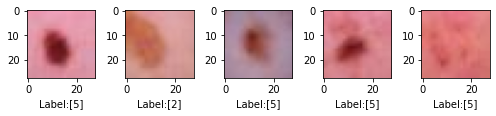


Images from derma_val_images_01


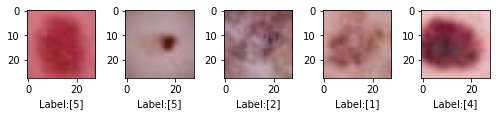


Images from derma_test_images_01


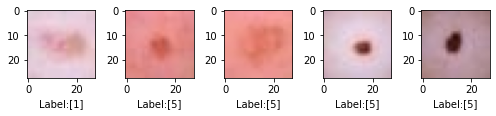


Images from retina_train_images_01


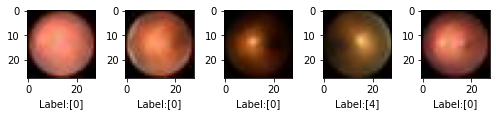


Images from retina_val_images_01


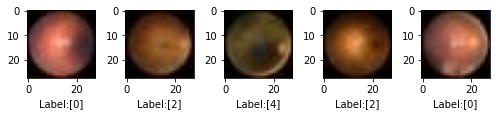


Images from retina_test_images_01


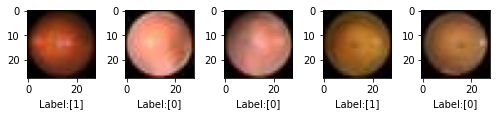

In [23]:
#Plot examples of each respective sub-dataset and annotate them with the ground truths.
#label denotes what class the image is labelled as.
for generator, generator_name in zip([derma_train_images_01, derma_val_images_01, derma_test_images_01, retina_train_images_01, retina_val_images_01, retina_test_images_01],
                                     ['derma_train_images_01', 'derma_val_images_01', 'derma_test_images_01', 'retina_train_images_01', 'retina_val_images_01', 'retina_test_images_01']):
  plot_from_generator(generator, generator_name, 5)

## 2.a) Data Processing - To Categorical
Currently the features are in the form of 0 to 6 but here 6 is not six times that of 1 so we must perform one-hot encoding through the use of the to_categorical function.

In [24]:
#Perform one hot encoding of the label names
derma_train_labels_categorical = to_categorical(derma_train_labels)
derma_test_labels_categorical = to_categorical(derma_test_labels)
derma_val_labels_categorical = to_categorical(derma_val_labels)

retina_train_labels_categorical = to_categorical(retina_train_labels)
retina_test_labels_categorical = to_categorical(retina_test_labels)
retina_val_labels_categorical = to_categorical(retina_val_labels)

In [25]:
#Print an example of this one hot encoding.
print(f"Original Labels {(derma_train_labels[:2].flatten())}")
print(f"\nLabels after one hot encoding\n {derma_train_labels_categorical[:2]}")

Original Labels [0 5]

Labels after one hot encoding
 [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


## 2.1) Derma models from simple rescaling

Lets first run a few models and compare the outputs:

1) A rescaling model with a conv 2d layer, maxpooling (with padding), flattened and using a dense layer (150) before the final output. We test a number of convolutional filter sizes to see the best size to proceed with.

2) As per 1, using a dropout after the pooling and after the dense layer.

In [22]:
#Loop through various convolutional window sizes and capture the histories for plotting later
variable_window_derma_histories = []
for i in [2,3,4,5]:
    variable_window_derma = model_creator(data_source = 'derma',
                                       name = 'simplistic_model_derma',
                                       data_augmentation= [layers.Rescaling(1./255)],
                                       list_of_layers= [['conv', 36, i],
                                                        ['pool', 2], 
                                                        ['flatten'],
                                                        ['dense', 150]])
'''
    #Comment out to reduce runtimes. Plots stored and loaded subsequently

    variable_window_derma_histories.append(variable_window_derma.fit(x = derma_train_images,
                                                            y = derma_train_labels_categorical,
                                                            batch_size = 1000,
                                                            verbose = 1,
                                                            epochs = 300,
                                                            validation_data = (derma_val_images, derma_val_labels_categorical)))
'''

Model: "simplistic_model_derma"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 36)        468       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 36)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7056)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               1058550   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1057      
Total params: 1,060,075
Trainable params: 1,060,075
Non-trainable params: 0
__________________________________

'\n    #Comment out to reduce runtimes. Plots stored and loaded subsequently\n\n    variable_window_derma_histories.append(variable_window_derma.fit(x = derma_train_images,\n                                                            y = derma_train_labels_categorical,\n                                                            batch_size = 1000,\n                                                            verbose = 1,\n                                                            epochs = 300,\n                                                            validation_data = (derma_val_images, derma_val_labels_categorical)))\n'

In [23]:
'''
#comment out, plots will be loaded from github
derma_window_2 = plot_history(variable_window_derma_histories[0], 300, 0.01, -200, title = 'simplistic_model_derma_window_2')
derma_window_3 = plot_history(variable_window_derma_histories[1], 300, 0.01, -280, title = 'simplistic_model_derma_window_3')
derma_window_4 = plot_history(variable_window_derma_histories[2], 300, 0.01, -300, title = 'simplistic_model_derma_window_4')
derma_window_5 = plot_history(variable_window_derma_histories[3], 300, 0.01, -300, title = 'simplistic_model_derma_window_5')
derma_window_2.savefig('derma_window_2')
derma_window_3.savefig('derma_window_3')
derma_window_4.savefig('derma_window_4')
derma_window_5.savefig('derma_window_5')

'''

"\n#comment out, plots will be loaded from github\nderma_window_2 = plot_history(variable_window_derma_histories[0], 300, 0.01, -200, title = 'simplistic_model_derma_window_2')\nderma_window_3 = plot_history(variable_window_derma_histories[1], 300, 0.01, -280, title = 'simplistic_model_derma_window_3')\nderma_window_4 = plot_history(variable_window_derma_histories[2], 300, 0.01, -300, title = 'simplistic_model_derma_window_4')\nderma_window_5 = plot_history(variable_window_derma_histories[3], 300, 0.01, -300, title = 'simplistic_model_derma_window_5')\nderma_window_2.savefig('derma_window_2')\nderma_window_3.savefig('derma_window_3')\nderma_window_4.savefig('derma_window_4')\nderma_window_5.savefig('derma_window_5')\n\n"

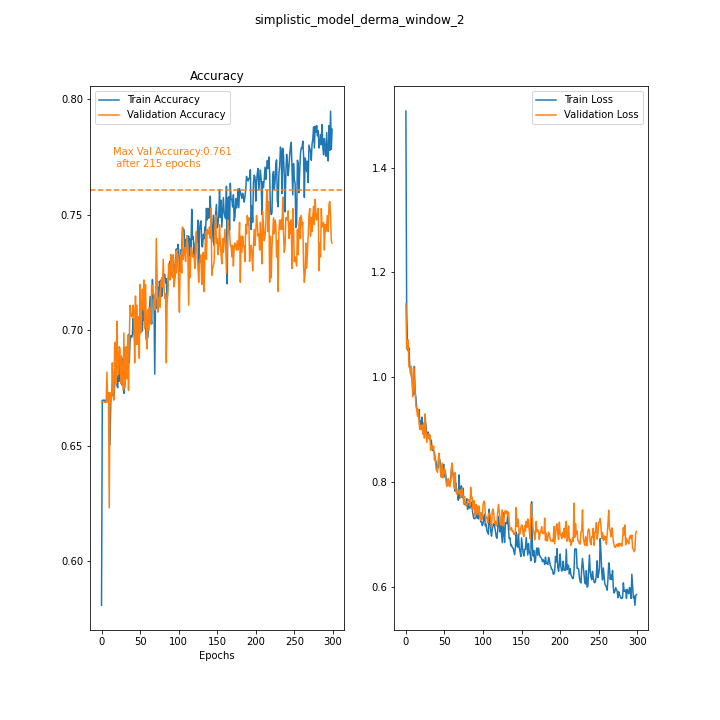

In [24]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/derma_window_2.png?raw=true'))

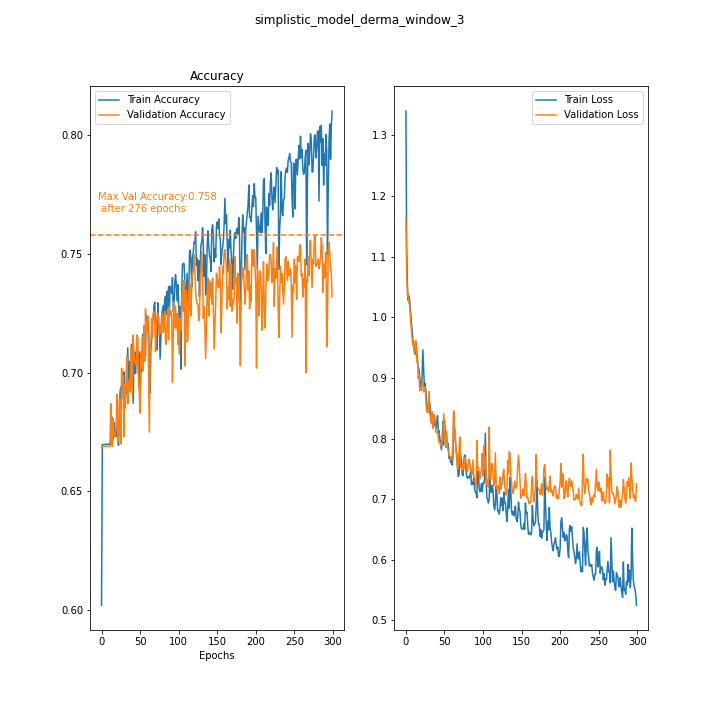

In [25]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/derma_window_3.png?raw=true'))

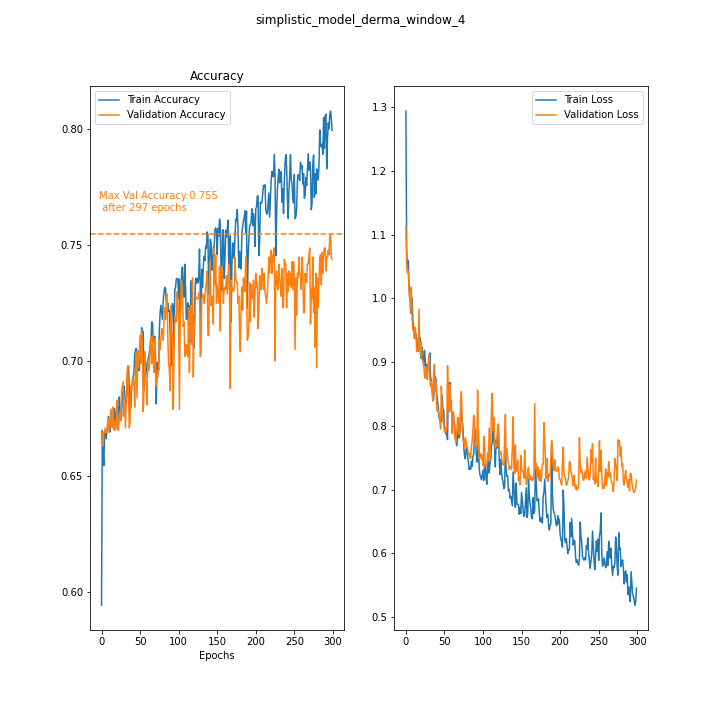

In [26]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/derma_window_4.png?raw=true'))

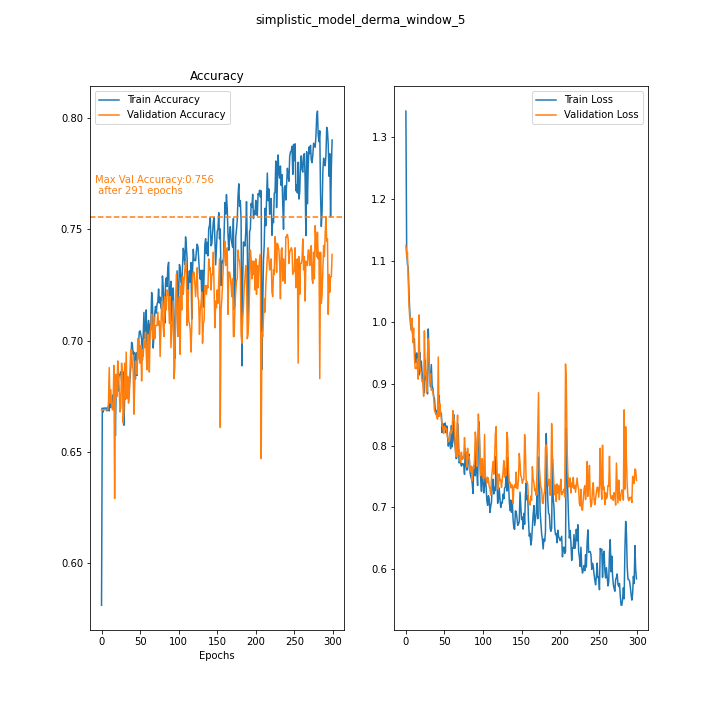

In [27]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/derma_window_5.png?raw=true'))

Overfitting is where training accuracy 
is increasing but validation accuracy is flatlining. 

The model should be stopped as soon as this is seen. As we can see this has occurred latest (and with higher accuracy) when the convolutional filter window size (kernel size) is set to 2x2, although this is not significantly higher than any other kernel size, it is predicted the small the kernel the finer the detail can be picked up.

In [28]:
simplistic_model_derma_dropout = model_creator(data_source = 'derma',                                               
                                       name = 'simplistic_model_derma_dropout',
                                       data_augmentation= [layers.Rescaling(1./255)],
                                       list_of_layers= [['conv', 36, 2],
                                                        ['pool', 2],
                                                        ['dropout', 0.2],
                                                        ['flatten'],
                                                        ['dense', 150],
                                                        ['dropout', 0.2]])

#comment out model fit to reduce runtime. Resulting plots stored in github and will be loaded from there

simplistic_model_derma_dropout_history = simplistic_model_derma_dropout.fit(x = derma_train_images,
                                                            y = derma_train_labels_categorical,
                                                            verbose = 1,
                                                            batch_size = 1000,
                                                            epochs = 1,
                                                            callbacks = val_loss_callback,
                                                            validation_data = (derma_val_images, derma_val_labels_categorical))


Model: "simplistic_model_derma_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 36)        468       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 36)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 36)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7056)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               1058550   
_________________________________________________________________
dropout_1 (Dropout)          (None, 

In [29]:
image = derma_train_images[10].reshape(1,28,28,3)
np.round(simplistic_model_derma_dropout.predict(image), 2)

array([[0.02, 0.09, 0.02, 0.  , 0.04, 0.84, 0.  ]], dtype=float32)

In [30]:
np.mean([0.38,
0.50,
0.47,
0.35,
0.45,
0.86,
0.78,
])

0.5414285714285715

In [31]:
0.86/0.35

2.4571428571428573

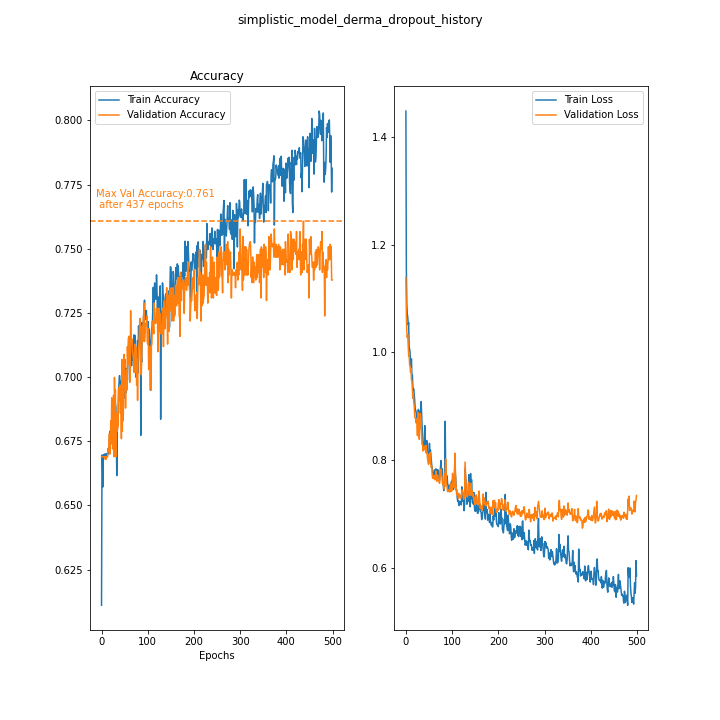

In [32]:
'''
simple_derma_dropout_plot = plot_history(simplistic_model_derma_dropout_history, 500, 0.005, -350, title = 'simplistic_model_derma_dropout_history')
simple_derma_dropout_plot.savefig('simple_derma_dropout_plot_')
'''
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/simple_derma_dropout_plot_.png?raw=true'))

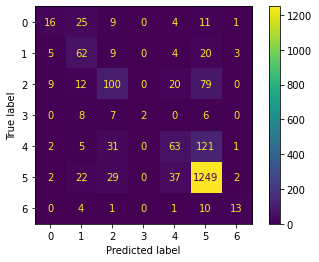

In [33]:
'''
simplistic_model_derma_dropout_test_predictions = np.argmax(simplistic_model_derma_dropout.predict(derma_test_images), axis =-1)
plot_confusion_matrix(derma_test_labels, simplistic_model_derma_dropout_test_predictions)
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/simplistic_model_derma_dropout_confusion_matrix_test.png?raw=True'))

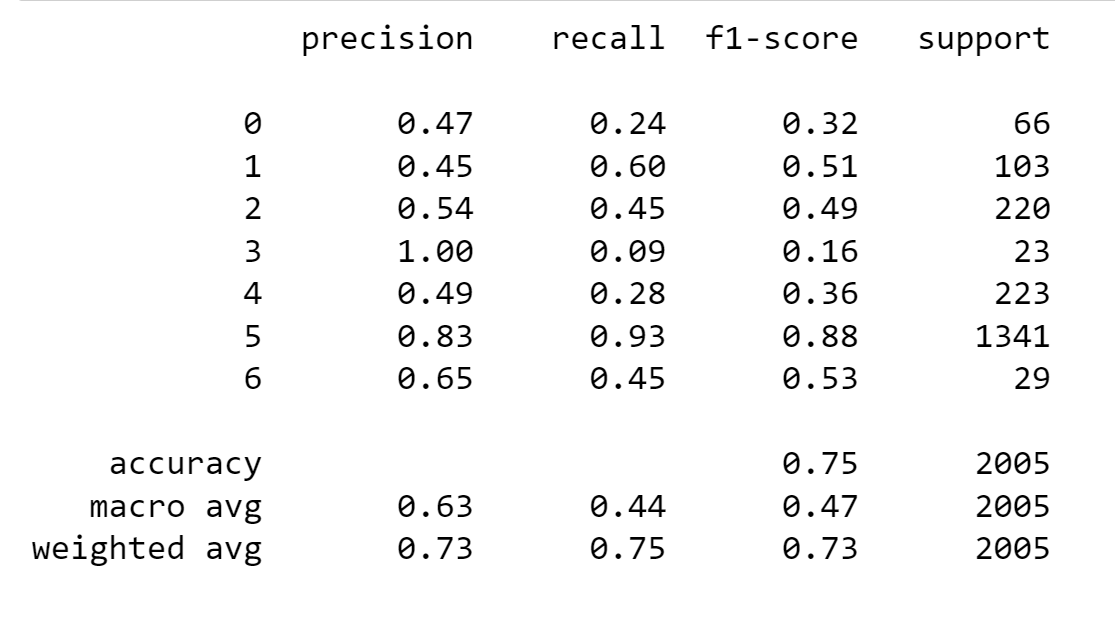

In [34]:
'''
print(classification_report(derma_test_labels, simplistic_model_derma_dropout_test_predictions, zero_division= 0))
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/simplistic_model_derma_dropout_classification_report.png?raw=True'))

Very similar effect seen with and without dropout. It would be expected that dropout would improve validation accuracy by reducing overfitting. We revisit this expectation when we generate a much larger model.

The confusion matrix shows mixed results. It is predicting the majority class very well. Class 1,2,4,6 are being predicted better than chance. Class 3 is not being predicted at all well, see recall. Interesting no other classed image is being predicted as 3 hence the 'perfect' precision. We shall revisit this issue in the feature engineering sections.

## 2.2) Retina models from simple rescaling

In [35]:
#Loop through various convolutional window sizes and capture the histories for plotting later
variable_window_retina_histories = []
for i in [2,3,4,5]:
    variable_window_retina = model_creator(data_source = 'retina',
                                       name = 'simplistic_model_retina',
                                       data_augmentation= [layers.Rescaling(1./255)],
                                       list_of_layers= [['conv', 36, i],
                                                        ['pool', 2], 
                                                        ['flatten'],
                                                        ['dense', 150]])
'''
#comment out mode fit to reduce runtime, resulting plots stored in github to be loaded
    variable_window_retina_histories.append(variable_window_retina.fit(x = retina_train_images,
                                                            y = retina_train_labels_categorical,
                                                            batch_size = 1000,
                                                            verbose = 1,
                                                            epochs = 300,
                                                            validation_data = (retina_val_images, retina_val_labels_categorical)))
'''

Model: "simplistic_model_retina"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 36)        468       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 36)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 7056)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 150)               1058550   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 755       
Total params: 1,059,773
Trainable params: 1,059,773
Non-trainable params: 0
_________________________________

'\n#comment out mode fit to reduce runtime, resulting plots stored in github to be loaded\n    variable_window_retina_histories.append(variable_window_retina.fit(x = retina_train_images,\n                                                            y = retina_train_labels_categorical,\n                                                            batch_size = 1000,\n                                                            verbose = 1,\n                                                            epochs = 300,\n                                                            validation_data = (retina_val_images, retina_val_labels_categorical)))\n'

In [36]:
'''
retina_window_2 = plot_history(variable_window_retina_histories[0], 300, 0.07, -100, title = 'simplistic_model_derma_window_2')
retina_window_3 = plot_history(variable_window_retina_histories[1], 300, 0.07, -70, title = 'simplistic_model_derma_window_3')
retina_window_4 = plot_history(variable_window_retina_histories[2], 300, 0.07, -30, title = 'simplistic_model_derma_window_4')
retina_window_5 = plot_history(variable_window_retina_histories[3], 300, 0.07, -10, title = 'simplistic_model_derma_window_5')
retina_window_2.savefig('retina_window_2')
retina_window_3.savefig('retina_window_3')
retina_window_4.savefig('retina_window_4')
retina_window_5.savefig('retina_window_5')
'''


"\nretina_window_2 = plot_history(variable_window_retina_histories[0], 300, 0.07, -100, title = 'simplistic_model_derma_window_2')\nretina_window_3 = plot_history(variable_window_retina_histories[1], 300, 0.07, -70, title = 'simplistic_model_derma_window_3')\nretina_window_4 = plot_history(variable_window_retina_histories[2], 300, 0.07, -30, title = 'simplistic_model_derma_window_4')\nretina_window_5 = plot_history(variable_window_retina_histories[3], 300, 0.07, -10, title = 'simplistic_model_derma_window_5')\nretina_window_2.savefig('retina_window_2')\nretina_window_3.savefig('retina_window_3')\nretina_window_4.savefig('retina_window_4')\nretina_window_5.savefig('retina_window_5')\n"

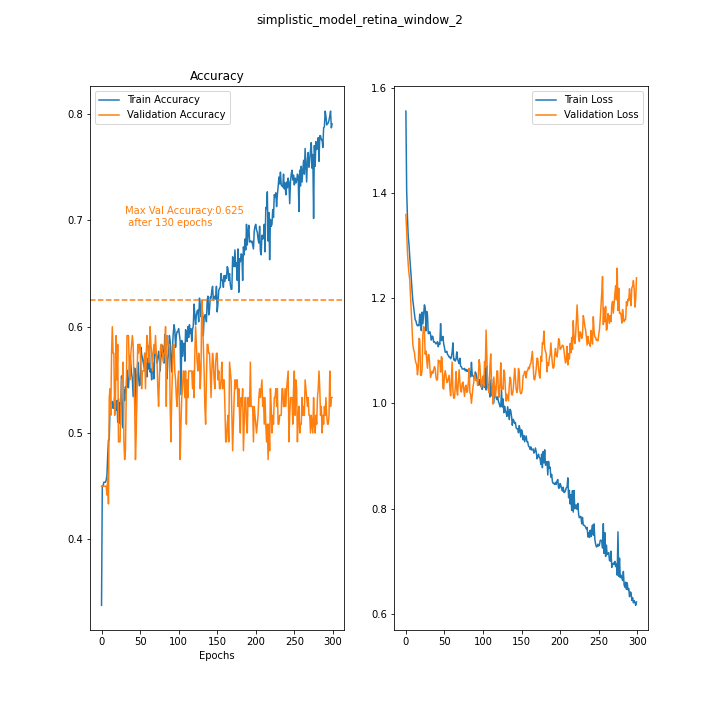

In [37]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/retina_window_2.png?raw=true'))

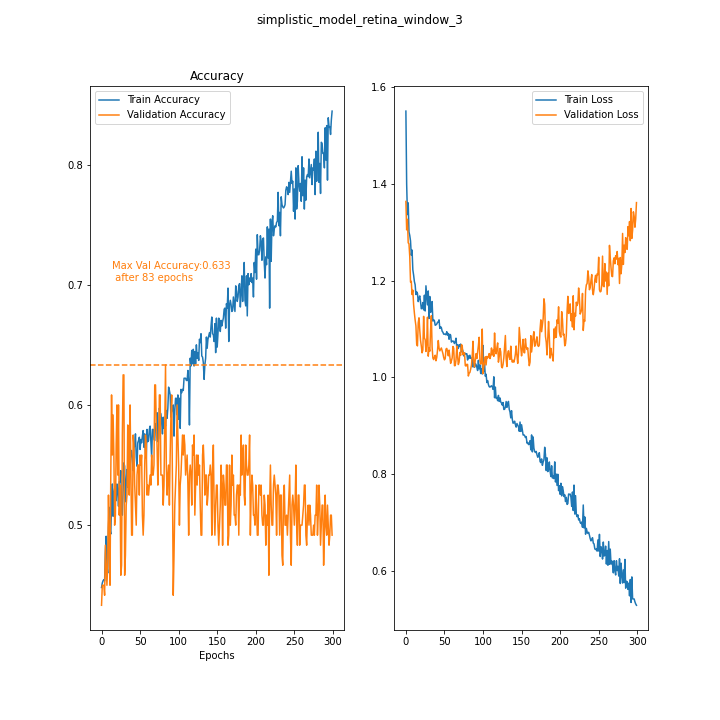

In [38]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/retina_window_3.png?raw=true'))

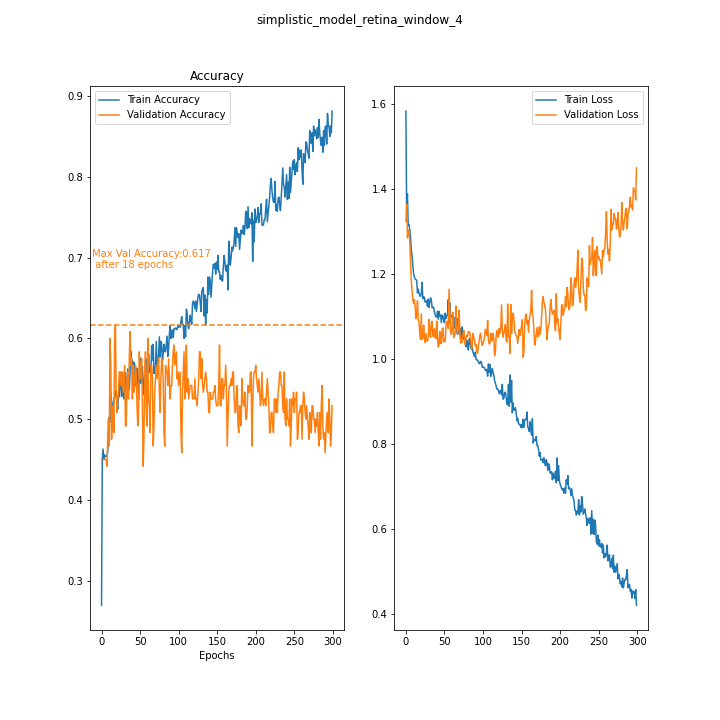

In [39]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/retina_window_4.png?raw=true'))

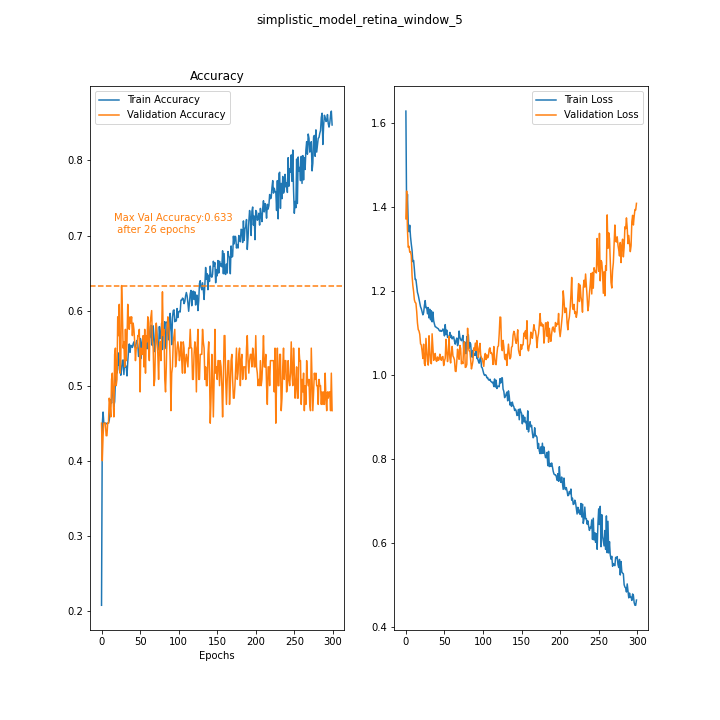

In [40]:
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/retina_window_5.png?raw=true'))

Best kernel size appears very closely cut. Looking at the crossing points in the loss curves we can see kernel size of 2 cross just after 100 epochs. For other window sizes it is below this. We will use a window size of 2.

In [41]:
simplistic_model_retina_dropout = model_creator(data_source = 'retina',
                                                name = 'simplistic_model_retina_dropout',
                                                data_augmentation= [layers.Rescaling(1./255)],
                                                list_of_layers= [['conv', 36, 2],
                                                                 ['pool', 2],
                                                                 ['dropout', 0.2],
                                                                 ['flatten'],
                                                                 ['dense', 150],
                                                                 ['dropout', 0.2],])
'''
simplistic_model_retina_dropout_history = simplistic_model_retina_dropout.fit(x = retina_train_images,
                                                            y = retina_train_labels,
                                                            verbose = 1,
                                                            epochs = 500,
                                                            validation_data = (retina_val_images, retina_val_labels))

'''

Model: "simplistic_model_retina_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 36)        468       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 36)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 36)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 7056)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 150)               1058550   
_________________________________________________________________
dropout_3 (Dropout)          (None,

'\nsimplistic_model_retina_dropout_history = simplistic_model_retina_dropout.fit(x = retina_train_images,\n                                                            y = retina_train_labels,\n                                                            verbose = 1,\n                                                            epochs = 500,\n                                                            validation_data = (retina_val_images, retina_val_labels))\n\n'

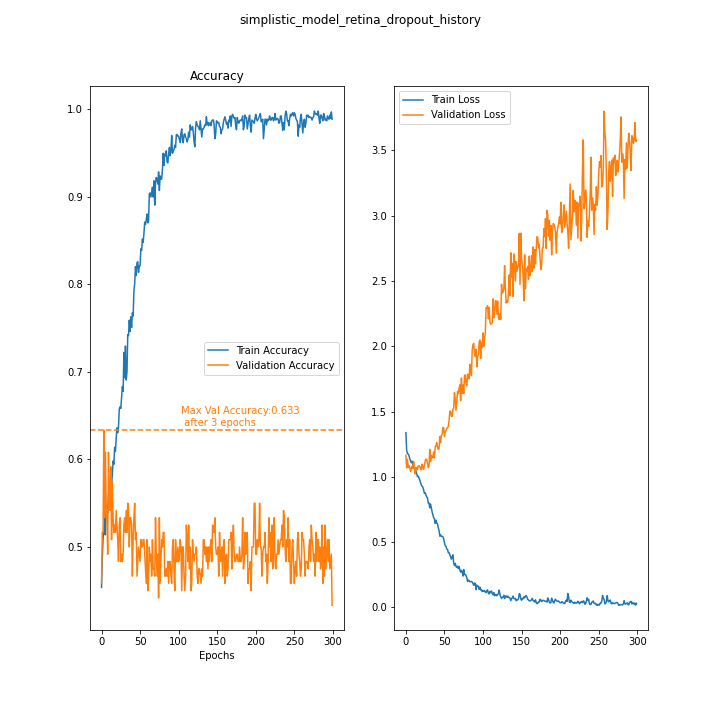

In [42]:
'''
saving plots to be reloaded
simple_retina_dropout_plot = plot_history(simplistic_model_retina_dropout_history, 500, 0.005, -350, title = 'simplistic_model_retina_dropout_history')
simple_retina_dropout_plot.savefig('simple_retina_dropout_plot__')
'''
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/simple_retina_dropout_plot__.png?raw=true'))

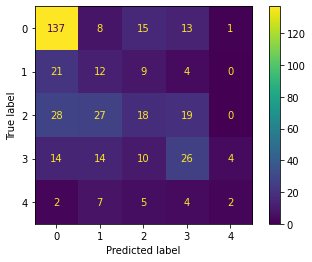

In [43]:
'''
multi_conv_model_retina_predictions_test = np.argmax(multi_conv_model_retina.predict(retina_test_images), axis = -1)
plot_confusion_matrix(retina_test_labels, multi_conv_model_retina_predictions_test)
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/simplistic_model_retina_dropout_confusion.png?raw=True'))

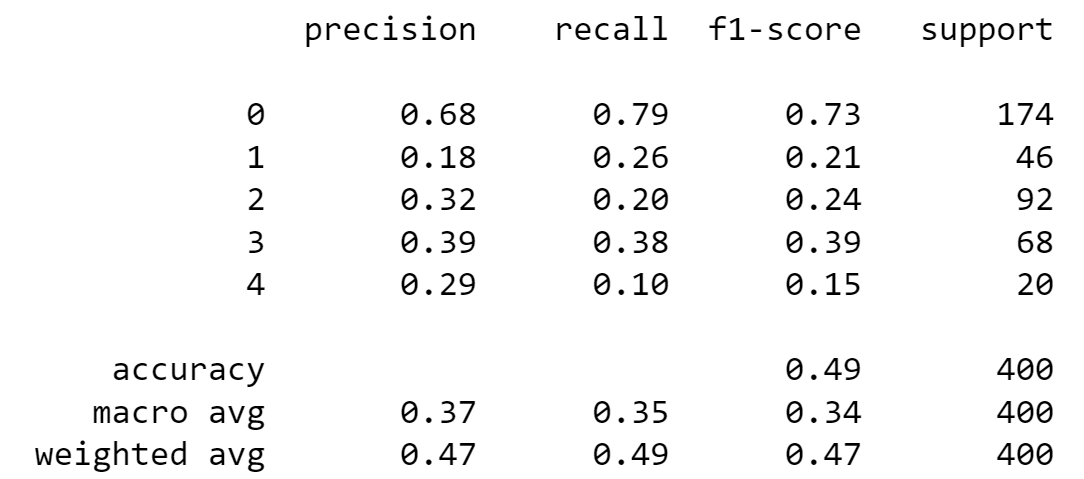

In [44]:
'''
print(classification_report(retina_test_labels, multi_conv_model_retina_predictions))
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/simplistic_model_retina_dropout_classification_report.png?raw=True'))

Interestingly we see a reduction in validation accuracy far earlier than in the previous runs. This was not expected but we clearly have a major issue with overfitting in this dataset.

Class zero is the majority and is has the highest precision and recall. Class 4 is being predicted very poorly, infact worse than randomly guessing.

Next we will look at some deeper layered models.

## 2.3) Derma deep model from simple rescaling

In [45]:
#Test a model with multiple layers to see if a more complex model can capture better (or more) information and perform better.
multi_conv_model_derma = model_creator(data_source = 'derma',                                               
                                       name = 'multi_conv_model_derma',
                                       data_augmentation= [layers.Rescaling(1./255)],
                                       list_of_layers= [['conv', 36, 2],
                                                        ['conv', 36, 3],
                                                        ['conv', 36, 4],
                                                        ['conv', 36, 5],
                                                        ['pool', 2],
                                                        ['conv', 36, 2],
                                                        ['conv', 36, 3],
                                                        ['conv', 36, 4],
                                                        ['conv', 36, 5],
                                                        ['pool', 2],
                                                        ['flatten'],
                                                        ['dense', 1000],
                                                        ['dropout', 0.5],
                                                        ['dense', 100],
                                                        ['dropout', 0.5]])
'''
#comment out model fit to reduce runtime. Resulting plots stored in github and will be loaded from there

multi_conv_model_derma_history = multi_conv_model_derma.fit(x = derma_train_images,
                                                            y = derma_train_labels_categorical,
                                                            verbose = 1,
                                                            batch_size = 1000,
                                                            epochs = 500,
                                                                            callbacks = val_loss_callback,
                                                            validation_data = (derma_val_images, derma_val_labels_categorical))

'''


Model: "multi_conv_model_derma"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 36)        468       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 36)        11700     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 36)        20772     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 36)        32436     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 36)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 

'\n#comment out model fit to reduce runtime. Resulting plots stored in github and will be loaded from there\n\nmulti_conv_model_derma_history = multi_conv_model_derma.fit(x = derma_train_images,\n                                                            y = derma_train_labels_categorical,\n                                                            verbose = 1,\n                                                            batch_size = 1000,\n                                                            epochs = 500,\n                                                                            callbacks = val_loss_callback,\n                                                            validation_data = (derma_val_images, derma_val_labels_categorical))\n\n'

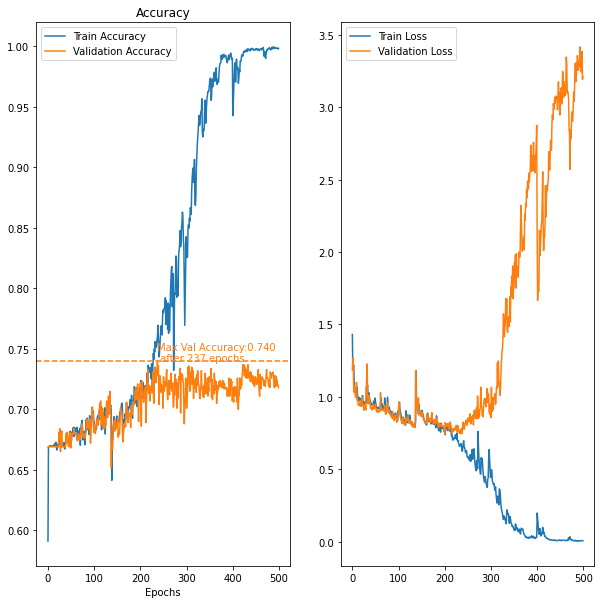

In [46]:
'''
plot_history(multi_conv_model_derma_history, 500)
'''
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/multi_conv_model_derma_history.png?raw=true'))

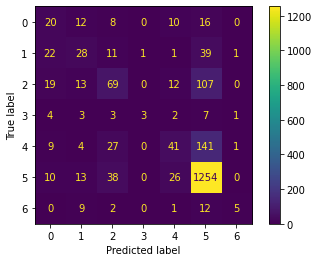

In [47]:
'''
plot_confusion_matrix(derma_test_labels, multi_conv_model_derma_predictions_test)
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/multi_conv_model_derma_confusion.png?raw=True'))

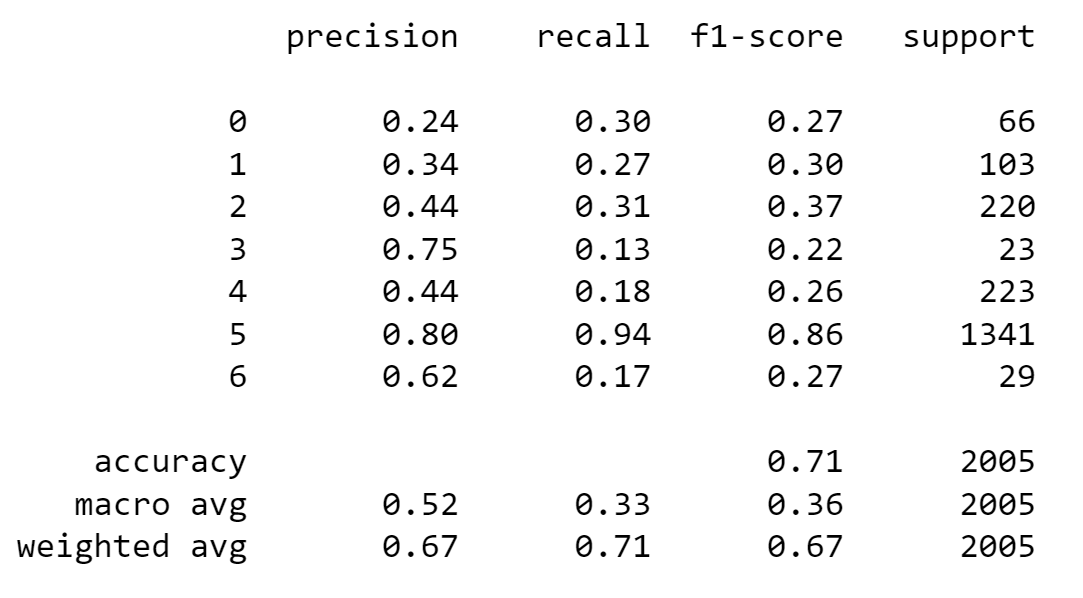

In [48]:
'''
print(classification_report(derma_test_labels, multi_conv_model_derma_predictions_test, zero_division= 0))
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/multi_conv_model_derma_classification_report.png?raw=True'))

Interestingly our scores are actually lower than we saw in the far simpler model.

## 2.4) Retina deep model from simple rescaling

In [49]:
#Test a model with multiple layers to see if a more complex model can capture better (or more) information and perform better.
multi_conv_model_retina = model_creator(data_source = 'retina',
                                                name = 'simplistic_model_retina_dropout',
                                                data_augmentation= [layers.Rescaling(1./255)],
                                                list_of_layers= [['conv', 36, 2],
                                                        ['conv', 36, 3],
                                                        ['conv', 36, 4],
                                                        ['conv', 36, 5],
                                                        ['pool', 2],
                                                        ['conv', 36, 2],
                                                        ['conv', 36, 3],
                                                        ['conv', 36, 4],
                                                        ['conv', 36, 5],
                                                        ['pool', 2],
                                                        ['flatten'],
                                                        ['dense', 1000],
                                                        ['dropout', 0.5],
                                                        ['dense', 100],
                                                        ['dropout', 0.5]])
'''
multi_conv_model_retina_history = multi_conv_model_retina.fit(x = retina_train_images,
                                                            y = retina_train_labels_categorical,
                                                            verbose = 1,
                                                            epochs = 500,
                                                              callbacks= val_loss_callback,
                                                            validation_data = (retina_val_images, retina_val_labels_categorical))
'''

Model: "simplistic_model_retina_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 36)        468       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 36)        11700     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 36)        20772     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 36)        32436     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 36)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None,

'\nmulti_conv_model_retina_history = multi_conv_model_retina.fit(x = retina_train_images,\n                                                            y = retina_train_labels_categorical,\n                                                            verbose = 1,\n                                                            epochs = 500,\n                                                              callbacks= val_loss_callback,\n                                                            validation_data = (retina_val_images, retina_val_labels_categorical))\n'

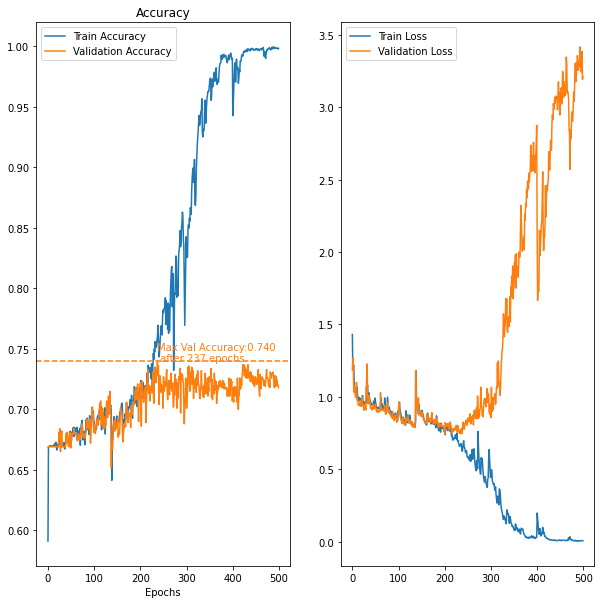

In [50]:
'''
plot_history(multi_conv_model_derma_history, 500)
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/e61f4b27162dfe3f0e5e1b9ef96caf5a1ec959f4/multi_conv_model_retina_history.png?raw=True'))

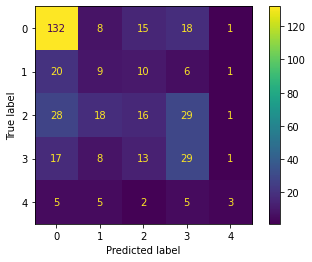

In [51]:
'''
multi_conv_model_retina_predictions_test = np.argmax(multi_conv_model_retina.predict(retina_test_images), axis = -1)
plot_confusion_matrix(retina_test_labels, multi_conv_model_retina_predictions_test)
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/multi_conv_model_retina_confusion.png?raw=True'))

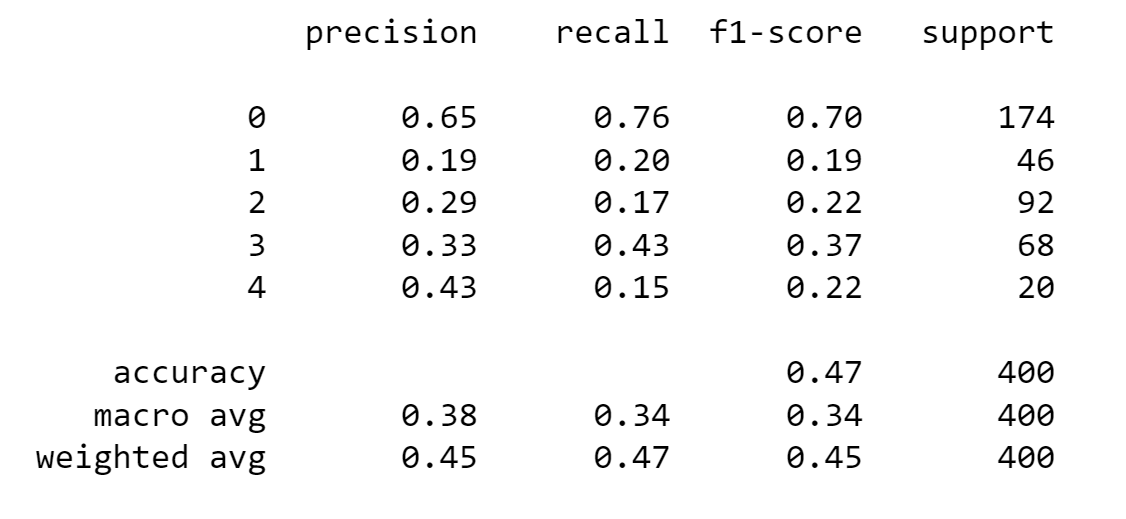

In [52]:
'''
print(classification_report(retina_test_labels, multi_conv_model_retina_predictions))
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/0a5e15fe2bdc21ca9fb1f640bf3829cc0ac75b92/multi_conv_model_retina_classification_report.png?raw=True'))

Scores are generally very comparable to those seen in the simplistic model. No benefit has been gained from the use of multiple convolutional layers.

# 3.a) Feature Engineering - Class Imbalance
Our two datasets have quite large class imbalances.

This can be described by the imbalance ratio in the training sets (ratio of percentage of most frequent class to the lowest frequency class)

For dermal this ratio is ~ 47 : 1

For retina this ratio is ~ 7.5: 1

There are multiple solutions to this style of problem:

Data-Centric Solutions

1) Undersampling. Reduce the majority classes frequency to match (or similar to) those of the minority classes.

2) Oversampling. Duplicate or synthetically create new examples to boost under-represented classes.

Algorithmic Solutions

3) Adjusting the class weights during method fit.

We first be looking at implementing oversampling, specifically we will use data augmentation to increase the available data sizes.



Images from derma_train_images_all_T


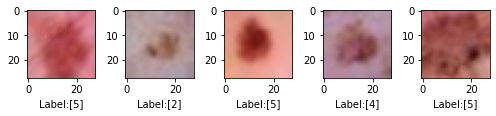


Images from retina_train_images_all_T


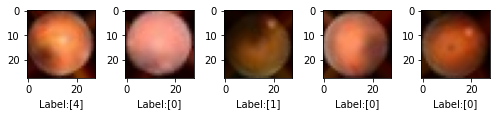

In [53]:
#Create image generators for the training datasets
def all_transformations_image_generator(file, target_file, batch_size):
  idg = ImageDataGenerator(rescale=1./255,
                           rotation_range = 45,
                          #  zoom_range = 0.5,
                          #  width_shift_range = 0.01,
                          #  height_shift_range = 0.2,
                           horizontal_flip = True,
                           vertical_flip = True,
                           fill_mode = 'nearest')
  #Removed zoom range and width/height shifts as data is well centered for retina
  
  return(idg.flow(x= file , y= target_file , batch_size = batch_size, shuffle = True))
#Create data generators
derma_train_images_all_T = all_transformations_image_generator(derma_train_images, derma_train_labels, 6000)

retina_train_images_all_T = all_transformations_image_generator(retina_train_images, retina_train_labels, 6000)

#Plot example images from these generated 'augmented' images.
for generator, generator_name in zip([derma_train_images_all_T, retina_train_images_all_T],
                                     ['derma_train_images_all_T', 'retina_train_images_all_T']):
  plot_from_generator(generator, generator_name, 5)

In [54]:
#Display detailed information about breakdown of classes within the derma dataset.
for file, file_name in zip(derma_files[3:], derma_file_names[3:]):
    unique_values, counts = np.unique(file, return_counts= True)
    max_count = np.amax(counts)
    max_count_index = np.argmax(counts)
    min_count = np.amin(counts)
    min_count_index = np.argmin(counts)
    print(f"\nCounts and classes in {file_name}:")
    print(f"Majority Class is {max_count_index}, with {max_count} images")
    print(f"Minority Class is {min_count_index}, with {min_count} images")


    for i in unique_values:
        print(f"{counts[i]} images for class {unique_values[i]}")


Counts and classes in derma_train_labels:
Majority Class is 5, with 4693 images
Minority Class is 3, with 80 images
228 images for class 0
359 images for class 1
769 images for class 2
80 images for class 3
779 images for class 4
4693 images for class 5
99 images for class 6

Counts and classes in derma_val_labels:
Majority Class is 5, with 671 images
Minority Class is 3, with 12 images
33 images for class 0
52 images for class 1
110 images for class 2
12 images for class 3
111 images for class 4
671 images for class 5
14 images for class 6

Counts and classes in derma_test_labels:
Majority Class is 5, with 1341 images
Minority Class is 3, with 23 images
66 images for class 0
103 images for class 1
220 images for class 2
23 images for class 3
223 images for class 4
1341 images for class 5
29 images for class 6


Clearly this is unrealistic. We only have 70 images for class 3 and class 6. However we can combine a reduced increase in size with an algorithmic solution (using class weights).

We will increase our minimum class to 3 times its size with augmentation. Then reduce the majority class to 2000. All other classes will be increased up proportionally up to 2000.

This will give at most ~8:1 ratio of majority to minority class

In [55]:
#Determine the maximum number of images to add if we want a maximum of 2000 images for each class.
original_train_data_sizes = [446, 721, 1590, 150, 1593, 2000, 201]
unique_value_index_lists = [[], [], [], [], [], [], []]
capped_index_values = [] 
class_addition_limit = [0], [0], [0], [0], [0], [0], [0]
class_addition_limit = list(class_addition_limit)
for index, value in enumerate(derma_train_labels):
  value = value[0]
  unique_value_index_lists[value].append(index)

for i, _ in enumerate(unique_value_index_lists):
  maximum_data_to_add = (2000- original_train_data_sizes[i])
  print(f"For Class {i} the maximum we can add is {maximum_data_to_add} images of augmentated data")
  capped_index_values.append(unique_value_index_lists[i][:maximum_data_to_add])
  class_addition_limit[i] = maximum_data_to_add

For Class 0 the maximum we can add is 1554 images of augmentated data
For Class 1 the maximum we can add is 1279 images of augmentated data
For Class 2 the maximum we can add is 410 images of augmentated data
For Class 3 the maximum we can add is 1850 images of augmentated data
For Class 4 the maximum we can add is 407 images of augmentated data
For Class 5 the maximum we can add is 0 images of augmentated data
For Class 6 the maximum we can add is 1799 images of augmentated data


In [56]:
#Create sufficient data to triple our minority class
[first_data, first_labels], [second_data, second_labels] = next(derma_train_images_all_T), next(derma_train_images_all_T)
additional_derma_data = np.concatenate([first_data, second_data])
additional_derma_labels = np.concatenate([first_labels, second_labels])

In [57]:
#Display the image classes and amounts we created
print("We have created:")
for i in range(7):
  print(f"{np.unique(additional_derma_labels, return_counts= True)[1][i]}\
  images for class {np.unique(additional_derma_labels, return_counts= True)[0][i]}")

We have created:
223  images for class 0
360  images for class 1
761  images for class 2
75  images for class 3
792  images for class 4
4699  images for class 5
97  images for class 6


In [58]:
#Add original and augmentation data together
augmentated_derma_train_images = np.concatenate([derma_train_images, additional_derma_data])
augmentated_derma_train_labels = np.concatenate([derma_train_labels, additional_derma_labels])

We will delete those for class 5 to a maximum of 2000

In [59]:
#set class 5 counter to be that of existing class 5 images + added class 5 images
class_5_counter = (4693+4705)
class_5_indexes = []
#loop through and add excessive class 5 values to a list
for index, value in enumerate(augmentated_derma_train_labels):
  if class_5_counter == 2000:
    break
  else: 
    if value == 5:
      class_5_indexes.append(index)
      class_5_counter -= 1


In [60]:
#Remove excesss class 5 images and labels
augmentated_derma_train_images = np.delete(augmentated_derma_train_images,class_5_indexes,axis = 0)
augmentated_derma_train_labels = np.delete(augmentated_derma_train_labels, class_5_indexes,axis = 0)

In [61]:
print("Now we have:")
for i in range(7):
  print(f"{np.unique(augmentated_derma_train_labels, return_counts= True)[1][i]}\
  images for class {np.unique(augmentated_derma_train_labels, return_counts= True)[0][i]}")

Now we have:
451  images for class 0
719  images for class 1
1530  images for class 2
155  images for class 3
1571  images for class 4
1994  images for class 5
196  images for class 6


Now to look at the retina dataset

In [62]:
#Determine the maximum number of images to add if we want a maximum of 2000 images for each class.
for file, file_name in zip(retina_files[3:], retina_file_names[3:]):
    unique_values, counts = np.unique(file, return_counts= True)
    max_count = np.amax(counts)
    max_count_index = np.argmax(counts)
    min_count = np.amin(counts)
    min_count_index = np.argmin(counts)
    print(f"\nCounts and classes in {file_name}:")
    print(f"Majority Class is {max_count_index}, with {max_count} images")
    print(f"Minority Class is {min_count_index}, with {min_count} images")


    for i in unique_values:
        print(f"{counts[i]} images for class {unique_values[i]}")


Counts and classes in retina_train_labels:
Majority Class is 0, with 486 images
Minority Class is 4, with 66 images
486 images for class 0
128 images for class 1
206 images for class 2
194 images for class 3
66 images for class 4

Counts and classes in retina_val_labels:
Majority Class is 0, with 54 images
Minority Class is 4, with 6 images
54 images for class 0
12 images for class 1
28 images for class 2
20 images for class 3
6 images for class 4

Counts and classes in retina_test_labels:
Majority Class is 0, with 174 images
Minority Class is 4, with 20 images
174 images for class 0
46 images for class 1
92 images for class 2
68 images for class 3
20 images for class 4


The dataset is far more balanced. And we saw earlier the derma model is overfitting the training data to give nearly 100% accuracy. Class imbalance is not an issue here.

We will expand the training data to become three times its size with data augmentation

In [63]:
#Add original and augmentation data together
augmentation_retina_data, augmentation_retina_labels  = next(retina_train_images_all_T)
augmentated_retina_train_images = np.concatenate([retina_train_images, augmentation_retina_data])
augmentated_retina_train_labels = np.concatenate([retina_train_labels, augmentation_retina_labels])

In [64]:
print("Now we have:")

for i in range(5):
  print(f"{np.unique(augmentated_retina_train_labels, return_counts= True)[1][i]} images for class {np.unique(augmentated_retina_train_labels, return_counts= True)[0][i]}")

Now we have:
972 images for class 0
256 images for class 1
412 images for class 2
388 images for class 3
132 images for class 4


# 3.b) Feature Engineering - Class Weights

Having performed augmentation and undersampling to reduce class imbalance there is one further step that can be peformed, class weights.

A higher class weight means the model will be prioritise the reduction in error in this class more.

Class weight therefore will be inversely proportional to our distribution of classes


In [65]:
#Calculate and display the class weights for our augmented data
class_weight_derma = compute_class_weight(class_weight  = 'balanced', classes = np.unique(augmentated_derma_train_labels.flatten()), y = augmentated_derma_train_labels.flatten())
class_weight_derma_dict = dict(zip(np.unique(augmentated_derma_train_labels), class_weight_derma))
class_weight_derma_dict

{0: 2.095660437123852,
 1: 1.3145241406715678,
 2: 0.6177404295051354,
 3: 6.097695852534562,
 4: 0.6016186232608893,
 5: 0.47399340879782204,
 6: 4.822157434402333}

In [66]:
#Calculate and display the class weights for our augmented data
class_weight_retina = compute_class_weight(class_weight  = 'balanced', classes = np.unique(augmentated_retina_train_labels.flatten()), y = augmentated_retina_train_labels.flatten())
class_weight_retina_dict = dict(zip(np.unique(augmentated_retina_train_labels), class_weight_retina))
class_weight_retina_dict

{0: 0.4444444444444444,
 1: 1.6875,
 2: 1.0485436893203883,
 3: 1.1134020618556701,
 4: 3.272727272727273}

Naturally we also need to convert these labels to categorical also

In [67]:
#Convert to one hot encoded labels
augmentated_retina_train_labels_categorical = to_categorical(augmentated_retina_train_labels)
augmentated_derma_train_labels_categorical = to_categorical(augmentated_derma_train_labels)

## 3.1) Derma Models Using Using Augmented Data and Class Weightings

In [72]:
#Test a very simple model with our augmented data
simplistic_model_derma_dropout_aug = model_creator(data_source = 'derma',
                                                name = 'simplistic_model_derma_dropout_aug',
                                                data_augmentation= [layers.Rescaling(1./255)],
                                                list_of_layers= [['conv', 100, 2],
                                                                 ['pool', 2],
                                                                 ['flatten'],
                                                                 ['dense', 150],
                                                                 ['dropout', 0.2]],
                                               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01) )
'''
#comment out to reduce runtime
simplistic_model_derma_dropout_aug.fit(x = augmentated_derma_train_images,
#                                    class_weight = class_weight_derma_dict,
                                   y = augmentated_derma_train_labels_categorical,
                                   verbose = 1,
                                   batch_size = 200,
                                   epochs = 500,
                                   steps_per_epoch = 10,
                                   callbacks = val_loss_callback,
                                   validation_data = (derma_val_images, derma_val_labels_categorical))

'''

Model: "simplistic_model_derma_dropout_aug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_14 (Rescaling)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 100)       1300      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 100)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 19600)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 150)               2940150   
_________________________________________________________________
dropout_9 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_29 (Dense)             (No

'\n#comment out to reduce runtime\nsimplistic_model_derma_dropout_aug.fit(x = augmentated_derma_train_images,\n#                                    class_weight = class_weight_derma_dict,\n                                   y = augmentated_derma_train_labels_categorical,\n                                   verbose = 1,\n                                   batch_size = 200,\n                                   epochs = 500,\n                                   steps_per_epoch = 10,\n                                   callbacks = val_loss_callback,\n                                   validation_data = (derma_val_images, derma_val_labels_categorical))\n\n'

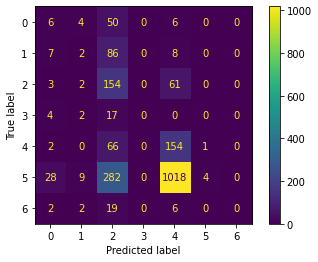

In [73]:

Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/993962e8623e41b0e6494279f1ae55bd64f289f3/simplistic_model_derma_aug_dropout_confusion_matrix_test.png?raw=true'))

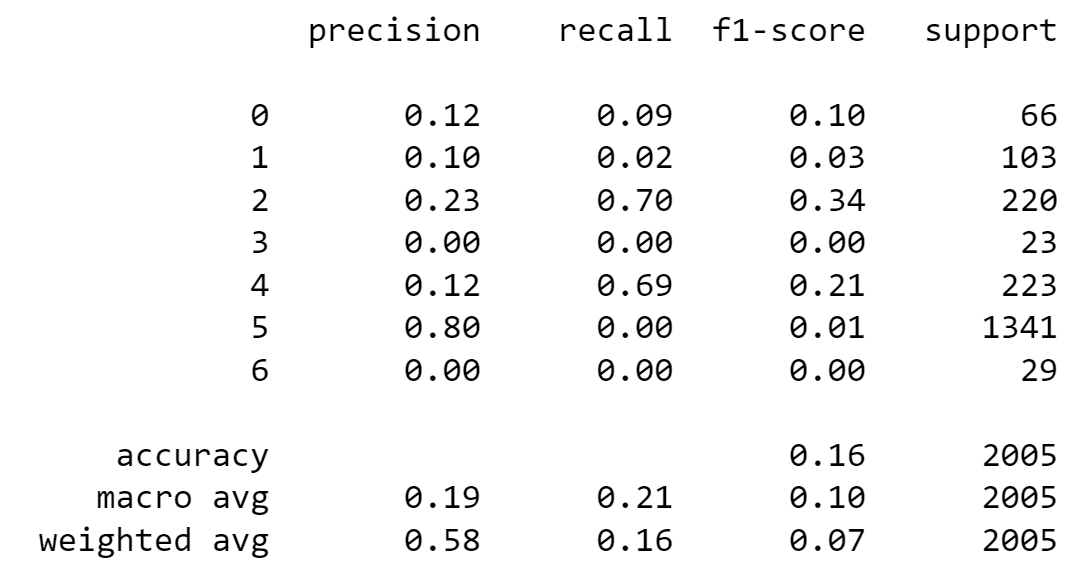

In [74]:
'''
print(classification_report(derma_test_labels, simplistic_model_derma_dropout_aug_predictions_test, zero_division=0))
'''

Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/993962e8623e41b0e6494279f1ae55bd64f289f3/simplistic_model_derma_dropout_aug_classification_report.png?raw=True'))

Prediction accuracy is greatly reduced (~16%). This confusion matrix and classification scores show the scale of the problem. Class 5 still dominates but is now hardly being predicted at all. Augmentation has not been successful across any of the classes.

## 3.2) Retina Model Using Augmented Data and Class Weightings

Now to repeat the retina model with the augmented data.

In [75]:
simplistic_model_retina_dropout_aug = model_creator(data_source = 'retina',
                                                name = 'simplistic_model_retina_dropout',
                                                data_augmentation= [layers.Rescaling(1./255)],
                                                list_of_layers= [['conv', 36, 2],
                                                                 ['pool', 2],
                                                                 ['dropout', 0.2],
                                                                 ['flatten'],
                                                                 ['dense', 150],
                                                                 ['dropout', 0.2],])
'''
simplistic_model_retina_dropout_history_aug = simplistic_model_retina_dropout_aug.fit(x = augmentated_retina_train_images, 
                                                                              class_weight = class_weight_retina_dict,
                                                                              y = augmentated_retina_train_labels_categorical,
                                                                              verbose = 1,
                                                                              epochs = 500,
                                                                              steps_per_epoch = 2,
                                                                              validation_data = (retina_val_images, retina_val_labels_categorical))

simplistic_model_retina_dropout_aug_predictions_test = np.argmax(simplistic_model_retina_dropout_aug.predict(retina_test_images), axis = -1)
plot_confusion_matrix(retina_test_labels, simplistic_model_retina_dropout_aug_predictions_test)
'''

Model: "simplistic_model_retina_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 36)        468       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 36)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 36)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 7056)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 150)               1058550   
_________________________________________________________________
dropout_11 (Dropout)         (None,

'\nsimplistic_model_retina_dropout_history_aug = simplistic_model_retina_dropout_aug.fit(x = augmentated_retina_train_images, \n                                                                              class_weight = class_weight_retina_dict,\n                                                                              y = augmentated_retina_train_labels_categorical,\n                                                                              verbose = 1,\n                                                                              epochs = 500,\n                                                                              steps_per_epoch = 2,\n                                                                              validation_data = (retina_val_images, retina_val_labels_categorical))\n\nsimplistic_model_retina_dropout_aug_predictions_test = np.argmax(simplistic_model_retina_dropout_aug.predict(retina_test_images), axis = -1)\nplot_confusion_matrix(retina_test_labels, simp

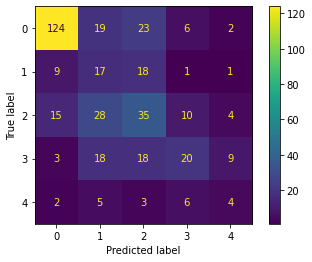

In [76]:
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/993962e8623e41b0e6494279f1ae55bd64f289f3/simplistic_model_retina_dropout_confusion_aug.png?raw=True'))

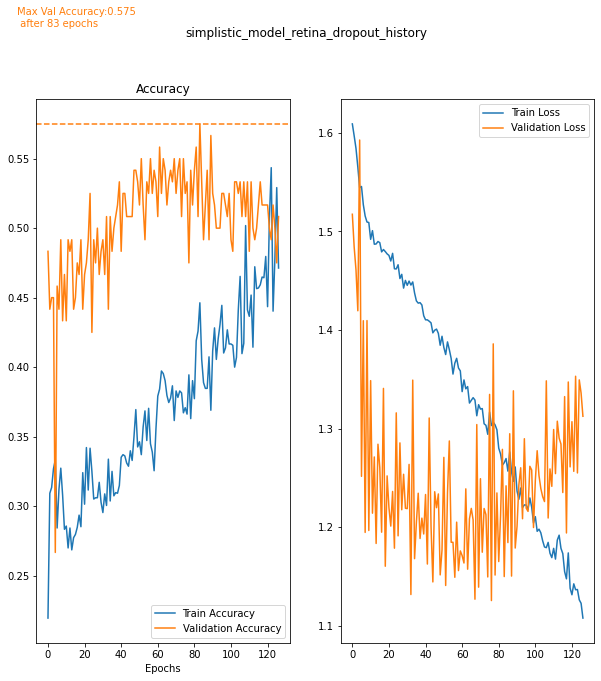

In [77]:
#plot_history(simplistic_model_retina_dropout_history_aug, 127, 0.07, -100, title = 'simplistic_model_retina_dropout_history')
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/ab6143bf1072664762b80857189e922b83c6a25c/simplistic_model_retina_dropout_history_aug.png?raw=True'))

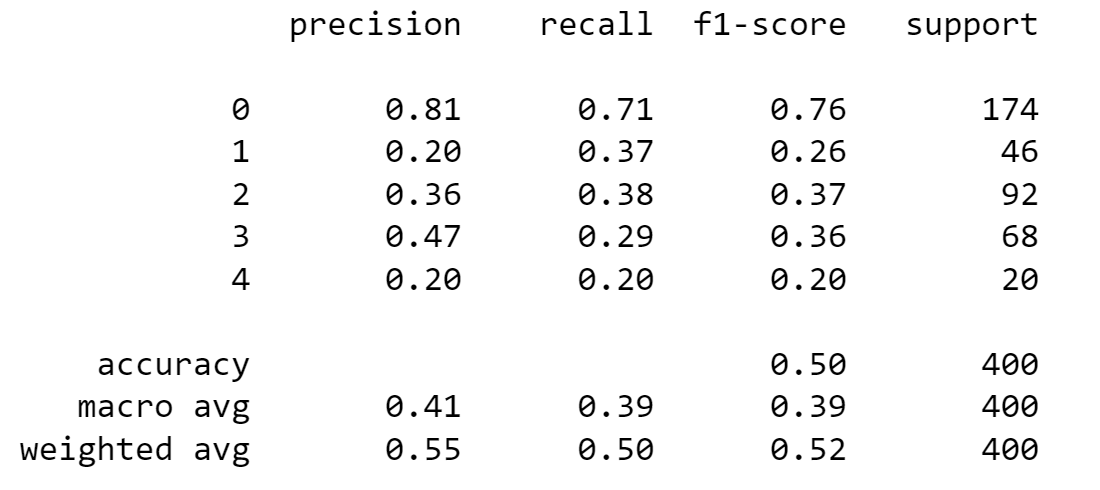

In [78]:
'''
print(classification_report(retina_test_labels, simplistic_model_retina_dropout_aug_predictions_test, zero_division=0))
'''
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/993962e8623e41b0e6494279f1ae55bd64f289f3/simplistic_model_retina_dropout_classification_report_aug.png?raw=True'))

Accuracies are only around 50% as seen historically and train accuracy does tend to overfit if left to run longer.

The scores are generally similar to those seen pre-augmentation and class weightings. Recall for class 2 has increased the most dramatically, seemingly at the expense of reduction in recall for class 0,1,3.

# 4.a) Feature Engineering Class Imbalance Fix by Oversampling

Augmentation has not been successful. One way to introduce class importance is to expand the dataset with repeated data for the minority classes

In [28]:
#create copies of the derma training data
derma_train_images_copy_no_class_5 = derma_train_images.copy()
derma_train_labels_copy_no_class_5 = derma_train_labels.copy()
original_class_5_indexes = []
#capture the indexes of the data for class 5
for index, value in enumerate(derma_train_labels):
    if value == 5:
        original_class_5_indexes.append(index)

#remove class 5 images from our copies
derma_train_images_copy_no_class_5 = np.delete(derma_train_images_copy_no_class_5, original_class_5_indexes,axis = 0)
derma_train_labels_copy_no_class_5 = np.delete(derma_train_labels_copy_no_class_5, original_class_5_indexes)
#print to show how many images are now in the new data
for i in range(6):
  print(f"{np.unique(derma_train_labels_copy_no_class_5, return_counts= True)[1][i]}\
  images for class {np.unique(derma_train_labels_copy_no_class_5, return_counts= True)[0][i]}")

228  images for class 0
359  images for class 1
769  images for class 2
80  images for class 3
779  images for class 4
99  images for class 6


In [29]:
derma_train_images_copy_no_class_5 = derma_train_images.copy()
derma_train_labels_copy_no_class_5 = derma_train_labels.copy()
original_class_5_indexes = []
for index, value in enumerate(derma_train_labels):
    if value == 5:
        original_class_5_indexes.append(index)
        
derma_train_images_copy_no_class_5 = np.delete(derma_train_images_copy_no_class_5, original_class_5_indexes,axis = 0)
derma_train_labels_copy_no_class_5 = np.delete(derma_train_labels_copy_no_class_5, original_class_5_indexes)
for i in range(6):
  print(f"{np.unique(derma_train_labels_copy_no_class_5, return_counts= True)[1][i]}\
  images for class {np.unique(derma_train_labels_copy_no_class_5, return_counts= True)[0][i]}")

228  images for class 0
359  images for class 1
769  images for class 2
80  images for class 3
779  images for class 4
99  images for class 6


In [30]:
oversampled_derma_train_images = np.concatenate([derma_train_images,
                                                 derma_train_images_copy_no_class_5,
                                                 derma_train_images_copy_no_class_5])
oversampled_derma_train_labels = np.concatenate([derma_train_labels.flatten(),
                                                 derma_train_labels_copy_no_class_5,
                                                 derma_train_labels_copy_no_class_5])

In [31]:
for i in range(7):
  print(f"{np.unique(oversampled_derma_train_labels, return_counts= True)[1][i]}\
  images for class {np.unique(oversampled_derma_train_labels, return_counts= True)[0][i]}")

684  images for class 0
1077  images for class 1
2307  images for class 2
240  images for class 3
2337  images for class 4
4693  images for class 5
297  images for class 6


In [32]:
oversampled_class_weight_derma = compute_class_weight(class_weight  = 'balanced', classes = np.unique(oversampled_derma_train_labels), y = oversampled_derma_train_labels)
oversampled_class_weight_derma_dict = dict(zip(np.unique(oversampled_derma_train_labels), oversampled_class_weight_derma))
oversampled_class_weight_derma_dict

{0: 2.430033416875522,
 1: 1.5433081310518637,
 2: 0.7204780481763576,
 3: 6.925595238095238,
 4: 0.7112292927440552,
 5: 0.3541749109616146,
 6: 5.596440596440597}

Again convert these to categorical

In [33]:
oversampled_derma_train_labels_categorical = to_categorical(oversampled_derma_train_labels)

## 4.1) Simplistic Derma Model With Oversampling

In [85]:
simplistic_model_derma_dropout_over = model_creator(data_source = 'derma',
                                                name = 'simplistic_model_derma_dropout',
                                                data_augmentation= [layers.Rescaling(1./255)],
                                                list_of_layers= [['conv', 100, 2],
                                                                 ['pool', 2],
                                                                 ['flatten'],
                                                                 ['dense', 150],
                                                                 ['dropout', 0.2]],
                                               optimizer = keras.optimizers.Adam(learning_rate = 0.01) )
'''
simplistic_model_derma_dropout_over_history = simplistic_model_derma_dropout_over.fit(x = oversampled_derma_train_images,
                                   class_weight = oversampled_class_weight_derma_dict,
                                   y = oversampled_derma_train_labels_categorical,
                                   verbose = 1,
                                   batch_size = 200,
                                   epochs = 500,
                                   steps_per_epoch = 10,
                                   callbacks = val_loss_callback,
                                   validation_data = (derma_val_images, derma_val_labels_categorical))

simplistic_model_derma_dropout_over_test_predictions = np.argmax(simplistic_model_derma_dropout_over.predict(derma_test_images), axis =-1)
plot_confusion_matrix(derma_test_labels, simplistic_model_derma_dropout_over_test_predictions)
'''


Model: "simplistic_model_derma_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 100)       1300      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 100)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 19600)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 150)               2940150   
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 

'\nsimplistic_model_derma_dropout_over_history = simplistic_model_derma_dropout_over.fit(x = oversampled_derma_train_images,\n                                   class_weight = oversampled_class_weight_derma_dict,\n                                   y = oversampled_derma_train_labels_categorical,\n                                   verbose = 1,\n                                   batch_size = 200,\n                                   epochs = 500,\n                                   steps_per_epoch = 10,\n                                   callbacks = val_loss_callback,\n                                   validation_data = (derma_val_images, derma_val_labels_categorical))\n\nsimplistic_model_derma_dropout_over_test_predictions = np.argmax(simplistic_model_derma_dropout_over.predict(derma_test_images), axis =-1)\nplot_confusion_matrix(derma_test_labels, simplistic_model_derma_dropout_over_test_predictions)\n'

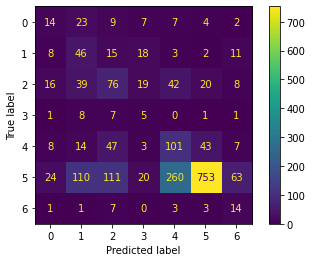

In [86]:
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/8f2787c557d06b1cd177f825fb009ecb107b8265/simplistic_model_derma_dropout_over_confusion.png?raw=true'))

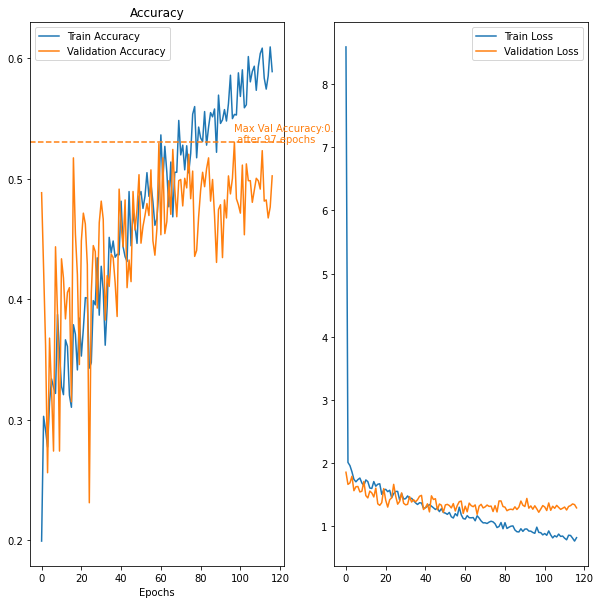

In [87]:
# plot_history(simplistic_model_derma_dropout_over_history, 117)
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/8f2787c557d06b1cd177f825fb009ecb107b8265/simplistic_model_derma_dropout_over_history.png?raw=true'))

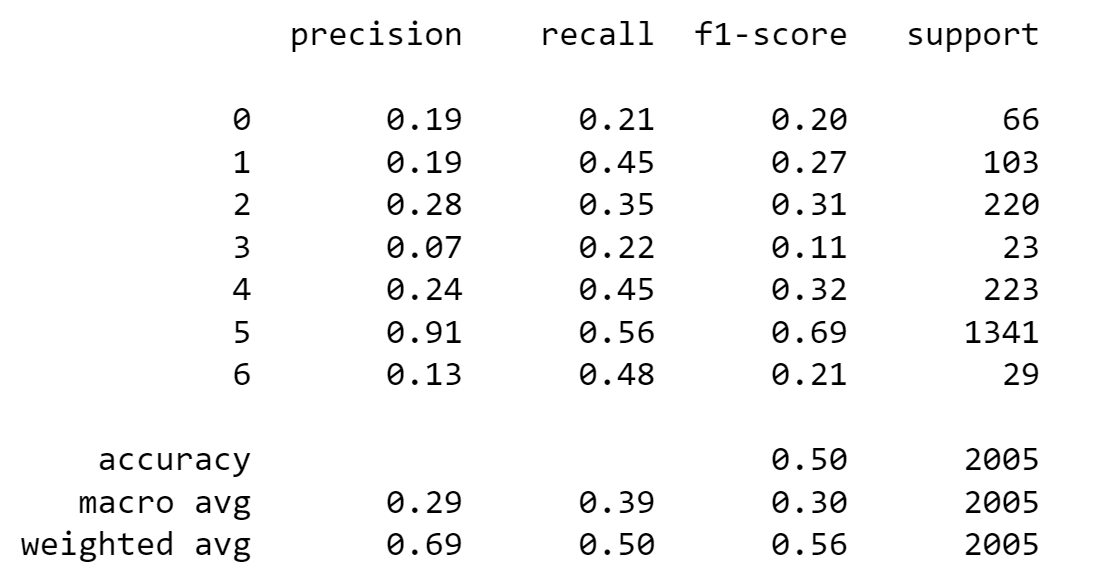

In [88]:
#print(classification_report(derma_test_labels, simplistic_model_derma_dropout_over_test_predictions))
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/8f2787c557d06b1cd177f825fb009ecb107b8265/simplistic_model_derma_dropout_over_class_report.png?raw=True'))

Some classes are still performing poorly. But overall predictions are >50%, and it is scoring far better than the augmented data. Compared to the simplistic dataset without class weightings all f-scores are worse. The only areas that improve are in precision (with the great exception that is class 3 which reduced from a precision of 1 to 0.07).

## 4.2) Deeper, Multi-Convolution Model Derma With Oversampling
Lets next expand the models complexity and run it for a lot more epochs to allow training to permeate all layers.

In [89]:
deep_model_derma_dropout_over = model_creator(data_source = 'derma',
                                                name = 'simplistic_model_derma_dropout',
                                                data_augmentation= [layers.Rescaling(1./255)],
                                                list_of_layers= [['conv', 360, 2],
                                                                 ['conv', 360, 3],
                                                                 ['conv', 360, 4],
                                                                 ['conv', 360, 5],
                                                                 ['pool', 2],
                                                                 ['conv', 360, 2],
                                                                 ['conv', 360, 3],
                                                                 ['conv', 360, 4],
                                                                 ['conv', 360, 5],
                                                                 ['pool', 2],
                                                                 ['flatten'],
                                                                 ['dense', 1000],
                                                                 ['dropout', 0.2],
                                                                ['dense', 150],
                                                                ['dropout', 0.2]],
                                               optimizer = keras.optimizers.Adam(learning_rate = 0.01) )
'''
deep_model_derma_dropout_over_history = deep_model_derma_dropout_over.fit(x = oversampled_derma_train_images,
                                   class_weight = oversampled_class_weight_derma_dict,
                                   y = oversampled_derma_train_labels_categorical,
                                   verbose = 1,
                                   batch_size = 10,
                                   epochs = 1000,
                                   steps_per_epoch = 50,
                                   callbacks = val_loss_callback,
                                   validation_data = (derma_val_images, derma_val_labels_categorical))

deep_model_derma_dropout_over_test_predictions = np.argmax(deep_model_derma_dropout_over.predict(derma_test_images), axis =-1)
plot_confusion_matrix(derma_test_labels, deep_model_derma_dropout_over_test_predictions)
'''

Model: "simplistic_model_derma_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_17 (Rescaling)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 360)       4680      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 360)       1166760   
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 360)       2073960   
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 360)       3240360   
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 360)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 

'\ndeep_model_derma_dropout_over_history = deep_model_derma_dropout_over.fit(x = oversampled_derma_train_images,\n                                   class_weight = oversampled_class_weight_derma_dict,\n                                   y = oversampled_derma_train_labels_categorical,\n                                   verbose = 1,\n                                   batch_size = 10,\n                                   epochs = 1000,\n                                   steps_per_epoch = 50,\n                                   callbacks = val_loss_callback,\n                                   validation_data = (derma_val_images, derma_val_labels_categorical))\n\ndeep_model_derma_dropout_over_test_predictions = np.argmax(deep_model_derma_dropout_over.predict(derma_test_images), axis =-1)\nplot_confusion_matrix(derma_test_labels, deep_model_derma_dropout_over_test_predictions)\n'

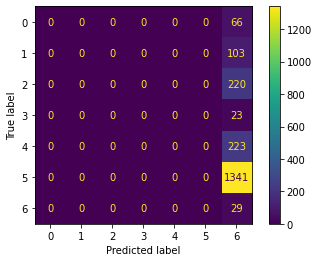

In [90]:
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/7decf0d949b53ca78333ae6a9fd3c10de37c4a5e/deep_model_derma_over_confusion.png?raw=true'))

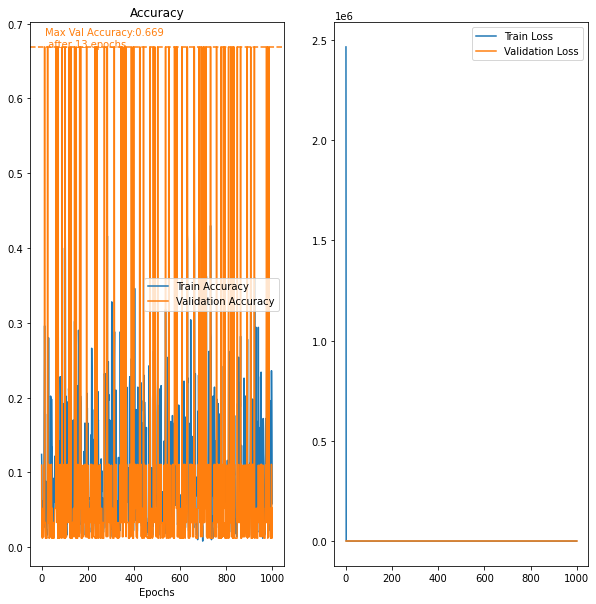

In [91]:
#plot_history(simplistic_model_derma_dropout_history, 1000)
Image.open(urlopen('https://github.com/adbandy/data_files/blob/main/deep_model_derma_dropout_oversample_history.png?raw=true'))

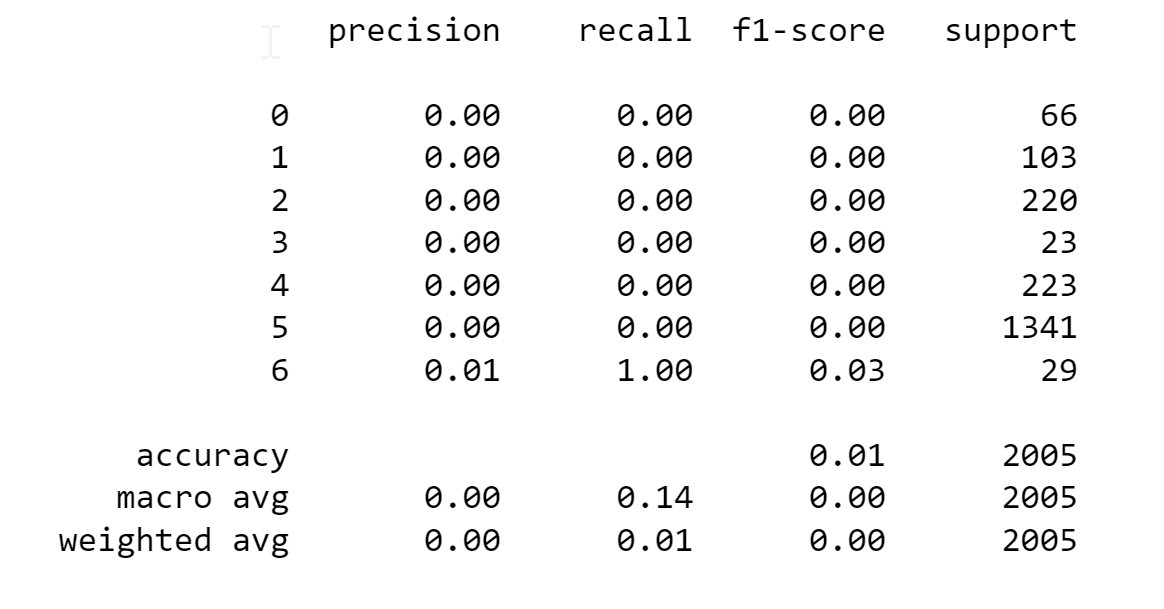

In [92]:
#print(classification_report(derma_test_labels, deep_model_derma_dropout_over_test_predictions))
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/7decf0d949b53ca78333ae6a9fd3c10de37c4a5e/deep_model_derma_over_class_report.png?raw=True'))

Batch size is small giving these spikes in validation accuracy. But we can see from the confusion matrix, the predictions are just not good.

## 4.3) Deeper Multi-Convolution Model Retina With Oversampling

Next lets see the outcomes from a deeper multiconvolutional layer in the retina dataset

In [93]:
multi_conv_model_retina_over = model_creator(data_source = 'retina',
                                                name = 'multi_conv_model_retina',
                                                data_augmentation= [layers.Rescaling(1./255)],
                                                list_of_layers= [['conv', 100, 2],
                                                                 ['conv', 100, 3],
                                                                 ['conv', 100, 4],
                                                                 ['conv', 100, 5],
                                                                 ['pool', 2],
                                                                 ['conv', 100, 2],
                                                                 ['pool', 2],
                                                                 ['conv', 100, 2],
                                                                 ['pool', 2],
                                                                 ['flatten'],
                                                                 ['dense', 1000],
                                                                 ['dropout', 0.2],
                                                                ['dense', 100],
                                                                ['dropout', 0.2]],
                                               optimizer = keras.optimizers.Adam(learning_rate = 0.001) )
'''
multi_conv_model_retina_over_history = multi_conv_model_retina_over.fit(x = retina_train_images, 
                                                                              class_weight = class_weight_retina_dict,
                                                                              y = retina_train_labels_categorical,
                                                                              verbose = 1,
                                                                              epochs = 1000,
                                                                              steps_per_epoch = 10,
                                                              batch_size = 100,
                                                                              callbacks = val_loss_callback,
                                                                              validation_data = (retina_val_images, retina_val_labels_categorical))

'''

Model: "multi_conv_model_retina"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_18 (Rescaling)     (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 100)       1300      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 100)       90100     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 100)       160100    
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 100)       250100    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14,

'\nmulti_conv_model_retina_over_history = multi_conv_model_retina_over.fit(x = retina_train_images, \n                                                                              class_weight = class_weight_retina_dict,\n                                                                              y = retina_train_labels_categorical,\n                                                                              verbose = 1,\n                                                                              epochs = 1000,\n                                                                              steps_per_epoch = 10,\n                                                              batch_size = 100,\n                                                                              callbacks = val_loss_callback,\n                                                                              validation_data = (retina_val_images, retina_val_labels_categorical))\n\n'

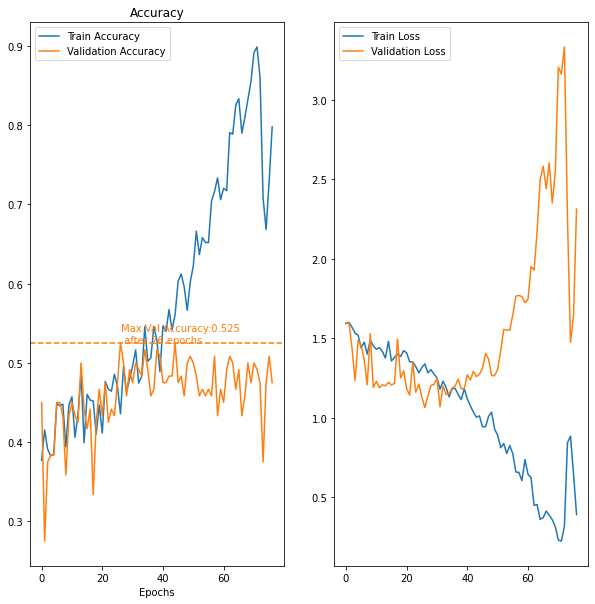

In [94]:
#plot_history(multi_conv_model_retina_over_history, 77)
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/599665b4891c7b0a11a92db0a2867b01703bd0a7/multi_conv_model_retina_over_history.png?raw=True'))

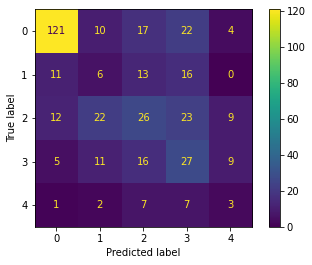

In [95]:
#multi_conv_model_retina_test_predictions = np.argmax(multi_conv_model_retina_over.predict(retina_test_images), axis =-1)
#plot_confusion_matrix(retina_test_labels, multi_conv_model_retina_test_predictions)
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/599665b4891c7b0a11a92db0a2867b01703bd0a7/multi_conv_model_retina_over_confusion.png?raw=True'))

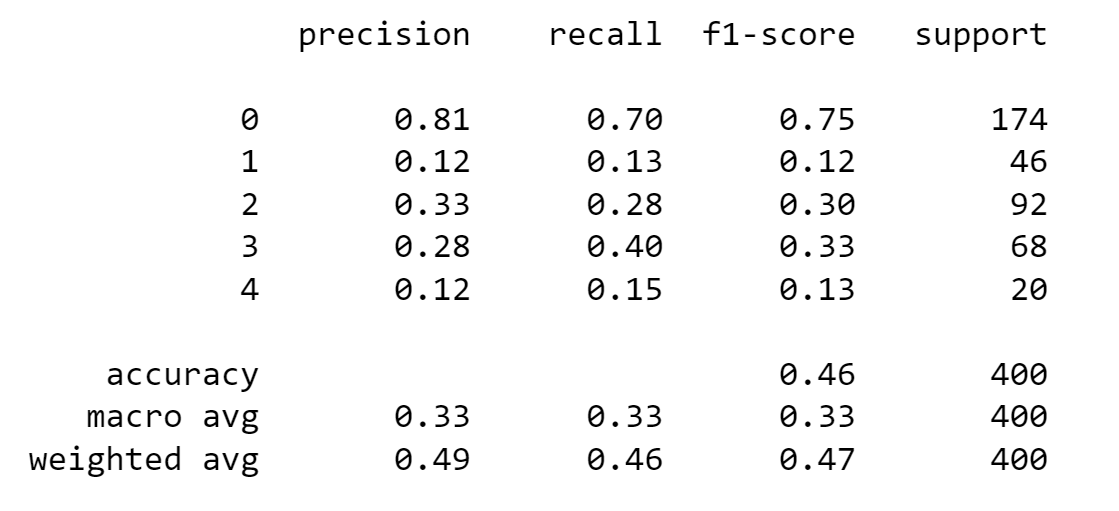

In [96]:
#print(classification_report(retina_test_labels, multi_conv_model_retina_test_predictions))
Image.open(urlopen('https://raw.githubusercontent.com/adbandy/data_files/599665b4891c7b0a11a92db0a2867b01703bd0a7/multi_conv_model_retina_over_classification.png?raw=True'))

Class 2,3,4 are predicted poorly. The majority class is predicted quite well.

# 5) Summary Of Group Made Models
Validation accuracies have hovered around 70% and 50% for derma and retina datasets respectively. Random guessing would have these as 14% and 20% respectively, so clearly the machine is learning and can be applied in some real sense, but is still lacking in a lot of areas.

Next we will persue transfer learning and harness the power of models that have been trained on huge datasets. Mostly these datasets will not be related to our derma or retina images but that might matter less than you would think.

Convolutional neural networks in the first layers are picking out edges, changes in contrast, curves etc. Parameters are then made from combinations of these and then more parameters from the combination of the combinations and so on. A pre-trained model knows which combinations of combinations of combinations (and so on) work well for their datasets. The closer the dataset represents ours the more likely we will get high accuracy.  

# 6) Existing Deep Neural Networks (Transfer Learning)

## 6.1) Inception 
Running model using imagenet weights. We are running Model on Retina dataset which has 5 classes. Methodology for transfer learning - 

**1) Data Augmentation:**


> **a) Categorization:** Convert labels to Categorical

> **b) Image Generator:** Generate Train images, output for generator will generate 50 replica train images for each sample train image per epoch. This process will be performed for both train and test image.

        
**2) Model Tuning:** 


> **Weights:** We have used pre-trained weights from imagenet for faster training.

> **Trainable Layers:** From Resnet50 model we have freezed all layers except three convolution layers in block 5.


> **Additional Layers:**
In Addition to trainable Convolution layers of Resnet50 model we have added GlobalAveragePooling2D layer to replcae fully connected blocks of our CNN. We have also added a Dropout layer to check overfitting on data. Finally we have added Dense layer of 5 expected possible output (classes) of images with Softmax as activation function.


> **Optimizer:** We have used Adam Optimizer which was giving better results when compared to SGD.


> **Checkpoint:** Checkpoint added for maximum value of accuracy on validation data.


> **Performance:**  Model is giving 53% accuracy on test Retina data. The highest ever accuracy achieved is as oposed to 52.8% accuracy after running model for 100 Epochs. For Derma Data we have managed to achieve 67% Accuracy as opposed to 73.1% accuracy after 30 Epochs.


>  




Retina Dataset 

Data preprocessing

In [97]:
#Convert to Categorical
new_train_lab = to_categorical(retina_train_labels)
new_val_lab = to_categorical(retina_val_labels)
new_test_lab = to_categorical(retina_test_labels)

Create a data generator for the augmentation.

In [98]:
inception_retina_train_images = keras.preprocessing.image.smart_resize(retina_train_images.copy(),(75, 75))
inception_retina_test_images= keras.preprocessing.image.smart_resize(retina_test_images.copy(),(75, 75))
inception_retina_val_images= keras.preprocessing.image.smart_resize(retina_val_images.copy(),(75, 75))

In [99]:
ret_train_datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip = True
    )
ret_train_datagen.fit(inception_retina_train_images)

train_gen = ret_train_datagen.flow(inception_retina_train_images, new_train_lab, shuffle=False,batch_size=50)

In [100]:
ret_val_datagen = ImageDataGenerator()
ret_val_datagen.fit(retina_val_images)

val_gen = ret_val_datagen.flow(inception_retina_val_images, new_val_lab, shuffle=False,batch_size=1)

### 6.1.a) Model Tuning and Performance on retinaMNIST

In [101]:
inception_model = InceptionV3(input_shape=(75,75,3),include_top=False,weights='imagenet')
for layer in inception_model.layers:
  layer.trainable =False

In [102]:
x=layers.Flatten()(inception_model.output)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dropout(0.3)(x)
x=layers.Dense(5,activation='softmax')(x)
full_inception_model = Model(inception_model.input,x)

In [103]:
full_inception_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [104]:
full_inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 37, 37, 32)   864         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [105]:
inception_history = full_inception_model.fit(train_gen,
                                   epochs=100,
                                   validation_data=val_gen,
                                   callbacks = val_loss_callback)

Epoch 1/100
22/22 [==============================] - 11s 261ms/step - loss: 30.2631 - accuracy: 0.3343 - val_loss: 10.3342 - val_accuracy: 0.3833
Epoch 2/100
22/22 [==============================] - 2s 115ms/step - loss: 21.9038 - accuracy: 0.3426 - val_loss: 10.9983 - val_accuracy: 0.4250
Epoch 3/100
22/22 [==============================] - 2s 114ms/step - loss: 17.8596 - accuracy: 0.3630 - val_loss: 7.5672 - val_accuracy: 0.4833
Epoch 4/100
22/22 [==============================] - 2s 113ms/step - loss: 14.9607 - accuracy: 0.3833 - val_loss: 7.6507 - val_accuracy: 0.4333
Epoch 5/100
22/22 [==============================] - 2s 114ms/step - loss: 13.7725 - accuracy: 0.3750 - val_loss: 8.7127 - val_accuracy: 0.4250
Epoch 6/100
22/22 [==============================] - 2s 114ms/step - loss: 12.1986 - accuracy: 0.3778 - val_loss: 6.6395 - val_accuracy: 0.4333
Epoch 7/100
22/22 [==============================] - 2s 114ms/step - loss: 9.2517 - accuracy: 0.3639 - val_loss: 5.4849 - val_accurac

In [106]:
full_inception_model.save('Inception.h5')

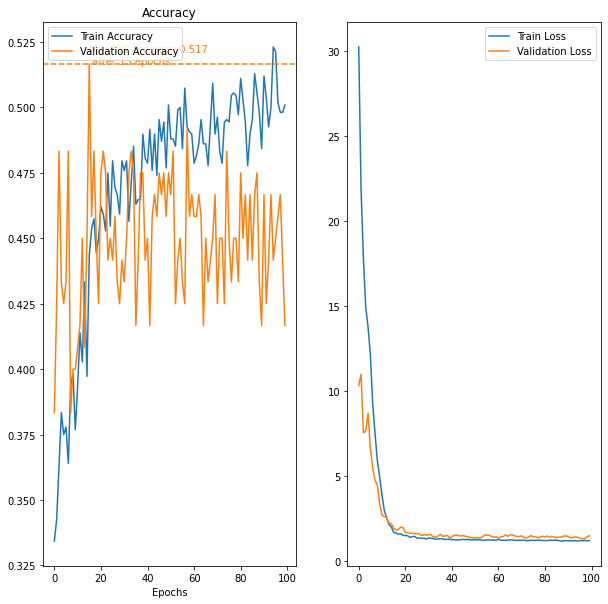

In [107]:
plot_history(inception_history, 100)

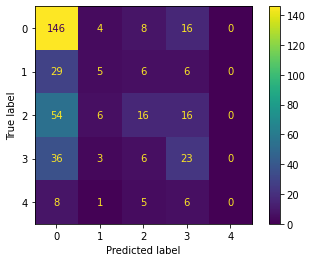

In [108]:
inception_retina_predictions = np.round(np.argmax(full_inception_model.predict(inception_retina_test_images),axis=-1),2)
plot_confusion_matrix(retina_test_labels,inception_retina_predictions)

In [109]:
print(classification_report(retina_test_labels, inception_retina_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.53      0.84      0.65       174
           1       0.26      0.11      0.15        46
           2       0.39      0.17      0.24        92
           3       0.34      0.34      0.34        68
           4       0.00      0.00      0.00        20

    accuracy                           0.48       400
   macro avg       0.31      0.29      0.28       400
weighted avg       0.41      0.47      0.42       400



## 6.2) ResNET50

In [110]:
resnet_retina_train_images = keras.preprocessing.image.smart_resize(retina_train_images,(32, 32))
resnet_retina_test_images= keras.preprocessing.image.smart_resize(retina_test_images,(32, 32))
resnet_retina_val_images= keras.preprocessing.image.smart_resize(retina_val_images,(32, 32))


Running model using imagenet weights. We are running Model on Retina dataset which has 5 classes. Methodology for transfer learning - 

**1) Data Augmentation:**


> **a) Categorization:** Convert labels to Categorical

> **b) Image Generator:** Generate Train images, output for generator will generate 50 replica train images for each sample train image per epoch. This process will be performed for both train and test image.

        
**2) Model Tuning:** 


> **Weights:** We have used pre-trained weights from imagenet for faster training.

> **Trainable Layers:** From Resnet50 model we have freezed all layers except three convolution layers in block 5.


> **Additional Layers:**
In Addition to trainable Convolution layers of Resnet50 model we have added GlobalAveragePooling2D layer to replcae fully connected blocks of our CNN. We have also added a Dropout layer to check overfitting on data. Finally we have added Dense layer of 5 expected possible output (classes) of images with Softmax as activation function.


> **Optimizer:** We have used Adam Optimizer which was giving better results when compared to SGD.


> **Checkpoint:** Checkpoint added for maximum value of accuracy on validation data.


> **Performance:**  Model is giving 53% accuracy on test Retina data. The highest ever accuracy achieved is as oposed to 52.8% accuracy after running model for 100 Epochs. For Derma Data we have managed to achieve 67% Accuracy as opposed to 73.1% accuracy after 30 Epochs.


>  




In [111]:
input_tensor = Input(shape=(32,32,3))

More data is required to train the model, Image Data generator generates 50 replica train images during training process for the model. Replica images are produced using parameters passed in the ImageDataGenerator.

In [112]:
ret_train_datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip = True,
    )
ret_train_datagen.fit(resnet_retina_train_images)

resnet_train_gen = ret_train_datagen.flow(resnet_retina_train_images, new_train_lab, shuffle=False,batch_size=50)

For validation data image augmentation is not needed.

In [113]:
ret_val_datagen = ImageDataGenerator()
ret_val_datagen.fit(retina_val_images)

val_gen = ret_val_datagen.flow(resnet_retina_val_images, new_val_lab, shuffle=False,batch_size=1)

### 6.2a) Model Tuning and Performance on retinaMNIST

In [114]:
resnet_base_model = ResNet50(include_top = False,
                       ##weights=None,
                       weights='imagenet',
                       input_tensor=input_tensor,
                       classes=5)

In [115]:
layer_list = ['conv5_block3_1_conv', 'conv5_block3_2_conv', 'conv5_block3_3_conv']
'''[base_model.get_layer(layer.name).trainable == False for layer in base_model.layers if layer.name not in list]'''
for layer in resnet_base_model.layers:
  if layer.name not in layer_list:
    resnet_base_model.get_layer(layer.name).trainable = False

In [116]:
y = resnet_base_model.output
y = GlobalAveragePooling2D()(y)
y = Dropout(0.7)(y) # add a few drop out for retina.
predictions = Dense(5, activation= 'softmax')(y)
resnet_model = Model(inputs = resnet_base_model.input, outputs = predictions)

In [117]:
optim = keras.optimizers.Adam(learning_rate=0.0001) # Tried SGD as well, getting best scores with Adam.
resnet_model.compile(optimizer= optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [119]:
#resnet_retina_checkpoint = keras.callbacks.ModelCheckpoint(filepath=resnet_retina_filepath,monitor="val_accuracy",mode='max',save_best_only=True,save_weights_only=False)

In [120]:
resnet_history_retina = resnet_model.fit(x=train_gen, validation_data=val_gen, epochs = 80, batch_size = 50)#,callbacks=[resnet_retina_checkpoint])

Epoch 1/80
22/22 [==============================] - 9s 222ms/step - loss: 2.4146 - accuracy: 0.3324 - val_loss: 2.4853 - val_accuracy: 0.2083
Epoch 2/80
22/22 [==============================] - 3s 122ms/step - loss: 1.5455 - accuracy: 0.4213 - val_loss: 2.3293 - val_accuracy: 0.1833
Epoch 3/80
22/22 [==============================] - 3s 129ms/step - loss: 1.4034 - accuracy: 0.4389 - val_loss: 2.2109 - val_accuracy: 0.2250
Epoch 4/80
22/22 [==============================] - 2s 111ms/step - loss: 1.3026 - accuracy: 0.4843 - val_loss: 2.1616 - val_accuracy: 0.2000
Epoch 5/80
22/22 [==============================] - 2s 114ms/step - loss: 1.2518 - accuracy: 0.4935 - val_loss: 2.1707 - val_accuracy: 0.2500
Epoch 6/80
22/22 [==============================] - 2s 110ms/step - loss: 1.2359 - accuracy: 0.4954 - val_loss: 2.1466 - val_accuracy: 0.2333
Epoch 7/80
22/22 [==============================] - 2s 113ms/step - loss: 1.2289 - accuracy: 0.4843 - val_loss: 2.1492 - val_accuracy: 0.2083
Epoch 

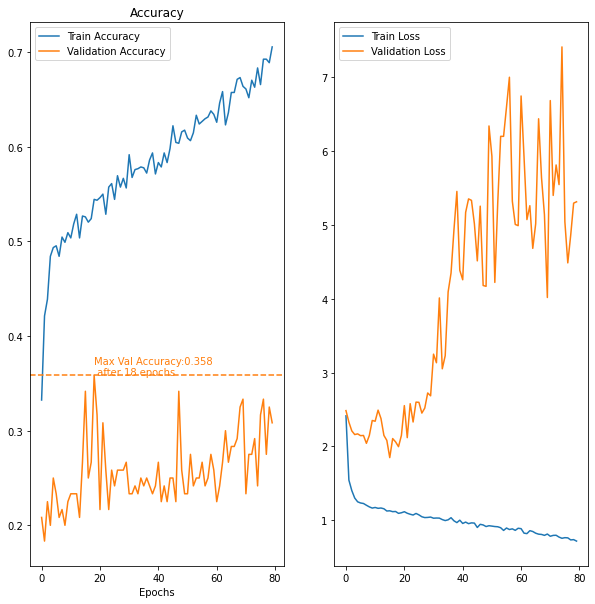

In [123]:
plot_history(resnet_history_retina, 80)

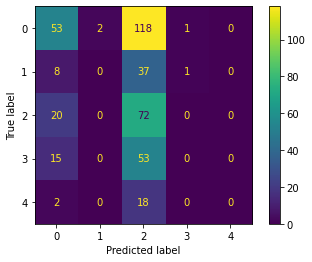

In [124]:
resnet_retina_predictions = np.argmax(resnet_model.predict(resnet_retina_test_images),axis=-1)
plot_confusion_matrix(retina_test_labels,resnet_retina_predictions)

In [125]:
print(classification_report(retina_test_labels, resnet_retina_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.54      0.30      0.39       174
           1       0.00      0.00      0.00        46
           2       0.24      0.78      0.37        92
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00        20

    accuracy                           0.31       400
   macro avg       0.16      0.22      0.15       400
weighted avg       0.29      0.31      0.25       400



### 6.2b) Model Tuning and Performance on dermaMNIST

In [126]:
input_tensor = Input(shape=(32,32,3))

In [127]:
resnet_augmentated_derma_train_images = keras.preprocessing.image.smart_resize(derma_train_images.copy(),(32, 32))
resnet_derma_test_images = keras.preprocessing.image.smart_resize(derma_test_images.copy(),(32, 32))
resnet_derma_val_images = keras.preprocessing.image.smart_resize(derma_val_images.copy(),(32, 32))
resnet_augmentated_derma_train_images = resnet_augmentated_derma_train_images/255
resnet_derma_test_images = resnet_derma_test_images/255
resnet_derma_val_images = resnet_derma_val_images/255

Data is required to be resized to 32*32

In [128]:
#Convert to Categorical
new_train_lab = to_categorical(derma_train_labels)
new_val_lab = to_categorical(derma_val_labels)
new_test_lab = to_categorical(derma_test_labels)

In [129]:
derma_train_datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True
    )
derma_train_datagen.fit(derma_train_images)

derma_train_gen = derma_train_datagen.flow(derma_train_images, new_train_lab, shuffle=False,batch_size=10)

In [130]:
derma_val_datagen = ImageDataGenerator()
derma_train_datagen.fit(derma_val_images)

derma_val_gen = derma_train_datagen.flow(derma_val_images, new_val_lab, shuffle=False,batch_size=10)

In [131]:
#resnet_derma_checkpoint = keras.callbacks.ModelCheckpoint(filepath=resnet_retina_filepath,monitor="val_accuracy",mode='max',save_best_only=True,save_weights_only=False)

In [132]:
derma_base_model = ResNet50(include_top = False,
                       weights='imagenet',
                       input_tensor=input_tensor,
                       classes=7)

Output classes are 7 in this case.

In [133]:
resnet_derma_list = ['conv5_block3_1_conv', 'conv5_block3_2_conv', 'conv5_block3_3_conv']

'''
[derma_base_model.get_layer(layer.name).trainable == False for layer in derma_base_model.layers if layer.name not in list]
'''

for layer in derma_base_model.layers:
  if layer.name not in resnet_derma_list:
    derma_base_model.get_layer(layer.name).trainable = False

In [134]:
'''count = 0
for layer in derma_base_model.layers:
  print(f"{count+1} {layer.name} trainable = {derma_base_model.get_layer(layer.name).trainable}")
  count+=1'''

'count = 0\nfor layer in derma_base_model.layers:\n  print(f"{count+1} {layer.name} trainable = {derma_base_model.get_layer(layer.name).trainable}")\n  count+=1'

In [135]:
x_derma = derma_base_model.output
x_derma = GlobalAveragePooling2D()(x_derma)
x_derma = Dropout(0.7)(x_derma)
#predictions_derma = Dense(7,kernel_regularizer=regularizers.l2(0.001), activation= 'softmax')(x_derma)
predictions_derma = Dense(7, activation= 'softmax')(x_derma)
#x_derma = Dropout(0.7)(x_derma) # To be removed
derma_model = Model(inputs = derma_base_model.input, outputs = predictions_derma)
# 1) Decrease Learning rate - decreased by 10 fold.
# 0.00001 and 0.0001 - higher val accuracy -- val_accuracy plateau at 66-67 and accuracy goes up to 72

# 2) Adding adidtional drop out layer.
# Model was unable to learn, underfit. https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
# 3) Increase epochs - 

In [136]:
optim = keras.optimizers.Adam(learning_rate=0.00001) #
#optim = keras.optimizers.Adam(learning_rate=0.0001) # Acc - 72 and val acc - 67
#optim = keras.optimizers.Adam(learning_rate=0.001) # Similar acc and val_acc
# learning rate - 0.0001 - 67% accuracy 
# learning rate - 0.00001 - 67% accuracy
derma_model.compile(optimizer= optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
derma_history = derma_model.fit(x=derma_train_gen, validation_data=derma_val_gen, epochs = 30, batch_size = 100)#,callbacks=[resnet_derma_checkpoint])

Epoch 1/30
701/701 [==============================] - 18s 21ms/step - loss: 2.8889 - accuracy: 0.5046 - val_loss: 1.2125 - val_accuracy: 0.6810
Epoch 2/30
701/701 [==============================] - 12s 17ms/step - loss: 1.4122 - accuracy: 0.6190 - val_loss: 0.9145 - val_accuracy: 0.6869
Epoch 3/30
701/701 [==============================] - 12s 17ms/step - loss: 1.0310 - accuracy: 0.6633 - val_loss: 0.8505 - val_accuracy: 0.6959
Epoch 4/30
701/701 [==============================] - 12s 17ms/step - loss: 0.9749 - accuracy: 0.6700 - val_loss: 0.8291 - val_accuracy: 0.7059
Epoch 5/30
701/701 [==============================] - 12s 18ms/step - loss: 0.9319 - accuracy: 0.6806 - val_loss: 0.8000 - val_accuracy: 0.7039
Epoch 6/30
701/701 [==============================] - 12s 18ms/step - loss: 0.9118 - accuracy: 0.6819 - val_loss: 0.8136 - val_accuracy: 0.6999
Epoch 7/30
701/701 [==============================] - 12s 18ms/step - loss: 0.8897 - accuracy: 0.6860 - val_loss: 0.8037 - val_accuracy:

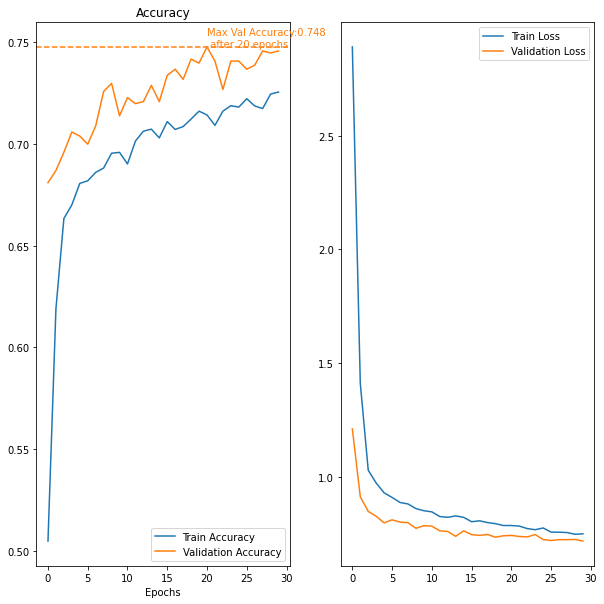

In [138]:
plot_history(derma_history, 30)

In [139]:
#derma_model.load_weights(resnet_retina_filepath)

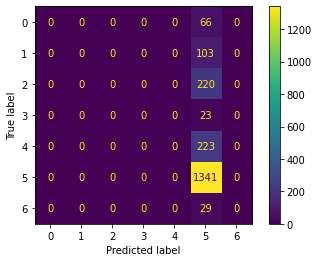

In [140]:
resnet_derma_predictions = np.argmax(derma_model.predict(resnet_derma_test_images),axis=-1)
plot_confusion_matrix(derma_test_labels,resnet_derma_predictions)

In [141]:
print(classification_report(derma_test_labels, resnet_derma_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00       220
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00       223
           5       0.67      1.00      0.80      1341
           6       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005



## 6.3) AlexNet

The Alexnet model code for creating the layer architecture was adopted from Kumar, 2022. The slightly modified version was developed for the CIFAR10 dataset
that consists of (32,32,3) sized images.Since retinaMNIST dataset is of a similar size this version was adopted and the images in our dataset
were rescaled to (32,32,3) to conform with this model architecture.

Unlike networks like VGG16 and RESNET, the keras api doesn't provide an out of the box solution for implementing Alexnet and therefore it's layers needed to be implemented.

Since the input shape of the dataset is different from the original Alexnet, pretrained weights were hard to obtain to initialize training. Therefore, weights have to be trained.

## 6.3a) AlexNet on RetinaMNIST data

In [142]:
#The adopted Alexnet implementation requires images to be in 32x32 size.
#Dataset images are resized and scaled
alexnet_retina_train_images = keras.preprocessing.image.smart_resize(retina_train_images.copy(),(32, 32))
alexnet_retina_test_images= keras.preprocessing.image.smart_resize(retina_test_images.copy(),(32, 32))
alexnet_retina_val_images= keras.preprocessing.image.smart_resize(retina_val_images.copy(),(32, 32))
alexnet_retina_train_images = alexnet_retina_train_images/255
alexnet_retina_test_images= alexnet_retina_test_images/255
alexnet_retina_val_images = alexnet_retina_val_images/255

In [143]:
#Producing copies of split dataset labels for alexnet dataset
alexnet_retina_train_lab = to_categorical(retina_train_labels.copy())
alexnet_retina_val_lab = to_categorical(retina_val_labels.copy())
alexnet_retina_test_lab = to_categorical(retina_test_labels.copy())

In [144]:
#Augment data to increase dataset size and also generalize model
alexnet_retina_train_gen = model_train_generator(alexnet_retina_train_images,alexnet_retina_train_lab)

In [145]:
#intializing alexnet
alexnet_model = create_alexnet(5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_138 (Conv2D)          (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization_94 (Batc (None, 8, 8, 96)          384       
_________________________________________________________________
activation_94 (Activation)   (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_95 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_95 (Activation)   (None, 4, 4, 256)         0

Categorical cross entropy was chosen for the model as this a multi class classification problem. The optimizer chosen is Adam optimizer with a learning rate of 0.0001

In [146]:
#Compilation of model
alexnet_model.compile(loss=keras.metrics.categorical_crossentropy, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

data augmentation was conducted on the training set to increase dataset size and class weights were also utilized to address class imabalances

In [149]:
#Training and validation of model
alexnet_history = alexnet_model.fit(x=alexnet_retina_train_gen,epochs=100,validation_data=(alexnet_retina_val_images,alexnet_retina_val_lab),class_weight=class_weight_retina_dict)

Epoch 1/100
22/22 [==============================] - 1s 30ms/step - loss: 1.5489 - accuracy: 0.3731 - val_loss: 1.8242 - val_accuracy: 0.0500
Epoch 2/100
22/22 [==============================] - 1s 29ms/step - loss: 1.4887 - accuracy: 0.4028 - val_loss: 1.8441 - val_accuracy: 0.0500
Epoch 3/100
22/22 [==============================] - 1s 28ms/step - loss: 1.4468 - accuracy: 0.4213 - val_loss: 1.8296 - val_accuracy: 0.0500
Epoch 4/100
22/22 [==============================] - 1s 27ms/step - loss: 1.4357 - accuracy: 0.4426 - val_loss: 1.8477 - val_accuracy: 0.0500
Epoch 5/100
22/22 [==============================] - 1s 28ms/step - loss: 1.4227 - accuracy: 0.4574 - val_loss: 1.8622 - val_accuracy: 0.0500
Epoch 6/100
22/22 [==============================] - 1s 26ms/step - loss: 1.4127 - accuracy: 0.4528 - val_loss: 1.8804 - val_accuracy: 0.0500
Epoch 7/100
22/22 [==============================] - 1s 27ms/step - loss: 1.4033 - accuracy: 0.4481 - val_loss: 1.8872 - val_accuracy: 0.0500
Epoch 

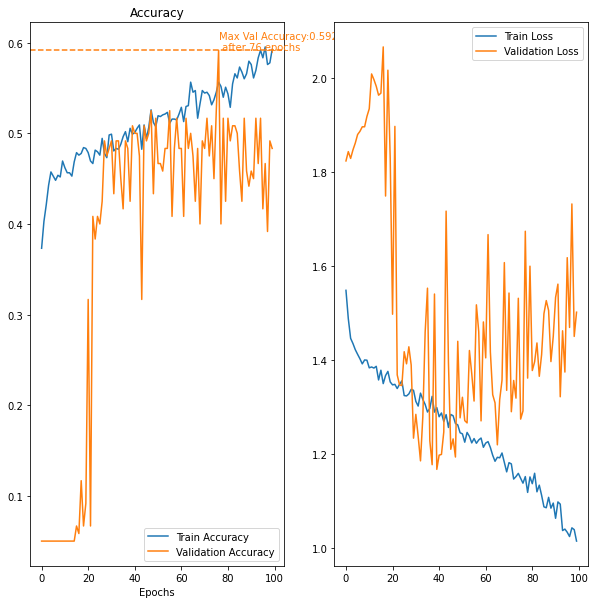

In [150]:
plot_history(alexnet_history, 100)

After initializing, The model was trained for a hundred epochs. validation accuracy shot up after 20 epochs and oscillated in the 0.4 - 0.5 range. the accuracy of the model increased and deviated from the validation accuracy after 50 epochs indicating an overfit after 50 epochs.
The highest validation accuracy detected was greater than 50 percent similiar to the benchmark accuracy reported in this dataset (Yang et al., 2022).The model also exhibited an increasing validation loss after 40 epochs.
Early stopping was done prior to running this script at highest validation accuracy before the deviation between both accuracies further increased and used in the UI part of the project.

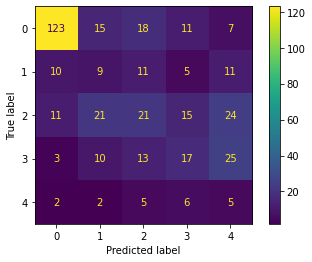

In [151]:
#Plotting confusion matrix for retina dataset using alexnet model for classification 
alexnet_retina_predictions = np.argmax(alexnet_model.predict(alexnet_retina_test_images),axis=-1)
plot_confusion_matrix(retina_test_labels,alexnet_retina_predictions)

In [152]:
#classification report for retina dataset with alexnet model
print(classification_report(retina_test_labels, alexnet_retina_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76       174
           1       0.16      0.20      0.17        46
           2       0.31      0.23      0.26        92
           3       0.31      0.25      0.28        68
           4       0.07      0.25      0.11        20

    accuracy                           0.44       400
   macro avg       0.34      0.33      0.32       400
weighted avg       0.51      0.44      0.46       400



As per the confusion matrix and the classifcation report. The alexnet model performed the best in classifying data labelled as class 0 with the highest recorded f1 score.
class 2 also performed better than random chance (refer to f1 score) while the other classes perfomed worse than random chance.

In [153]:
alexnet_model.evaluate(alexnet_retina_test_images,alexnet_retina_test_lab)

13/13 [==============================] - 0s 5ms/step - loss: 1.5328 - accuracy: 0.4375


[1.5328418016433716, 0.4375]

##Alexnet for DermaMNIST

In [155]:
#The adopted Alexnet implementation requires images to be in 32x32 size
alexnet_augmentated_derma_train_images = keras.preprocessing.image.smart_resize(oversampled_derma_train_images.copy(),(32, 32))
alexnet_derma_test_images = keras.preprocessing.image.smart_resize(derma_test_images.copy(),(32, 32))
alexnet_derma_val_images = keras.preprocessing.image.smart_resize(derma_val_images.copy(),(32, 32))
alexnet_augmentated_derma_train_images = alexnet_augmentated_derma_train_images/255
alexnet_derma_test_images = alexnet_derma_test_images/255
alexnet_derma_val_images = alexnet_derma_val_images/255

In [156]:
#Conversion of labels using to_categorical function
alexnet_derm_train_lab = to_categorical(oversampled_derma_train_labels.copy())
alexnet_derm_val_lab = to_categorical(derma_val_labels.copy())
alexnet_derm_test_lab = to_categorical(derma_test_labels.copy())

In [157]:
#data augmentation to increase size of training set and also facilitate generalization of model
alexnet_derm_train_gen = model_train_generator(alexnet_augmentated_derma_train_images,alexnet_derm_train_lab)

In [158]:
derma_alexnet = create_alexnet(7)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization_103 (Bat (None, 8, 8, 96)          384       
_________________________________________________________________
activation_103 (Activation)  (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_104 (Bat (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_104 (Activation)  (None, 4, 4, 256)        

In [159]:
#Training and validating the model with training and validation set
derma_alexnet.compile(loss=keras.metrics.categorical_crossentropy, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
derma_alexnet_history = derma_alexnet.fit(x=alexnet_derm_train_gen,epochs=100,validation_data=(alexnet_derma_val_images,alexnet_derm_val_lab))

Epoch 1/100
233/233 [==============================] - 9s 30ms/step - loss: 1.7653 - accuracy: 0.3931 - val_loss: 2.6033 - val_accuracy: 0.1097
Epoch 2/100
233/233 [==============================] - 6s 25ms/step - loss: 1.6026 - accuracy: 0.4706 - val_loss: 1.7237 - val_accuracy: 0.1715
Epoch 3/100
233/233 [==============================] - 6s 25ms/step - loss: 1.5342 - accuracy: 0.5079 - val_loss: 1.4236 - val_accuracy: 0.5115
Epoch 4/100
233/233 [==============================] - 6s 26ms/step - loss: 1.4880 - accuracy: 0.5317 - val_loss: 1.3053 - val_accuracy: 0.5783
Epoch 5/100
233/233 [==============================] - 6s 25ms/step - loss: 1.4477 - accuracy: 0.5551 - val_loss: 1.2862 - val_accuracy: 0.5434
Epoch 6/100
233/233 [==============================] - 6s 25ms/step - loss: 1.4177 - accuracy: 0.5714 - val_loss: 1.1473 - val_accuracy: 0.6032
Epoch 7/100
233/233 [==============================] - 6s 26ms/step - loss: 1.3816 - accuracy: 0.5913 - val_loss: 1.4584 - val_accuracy:

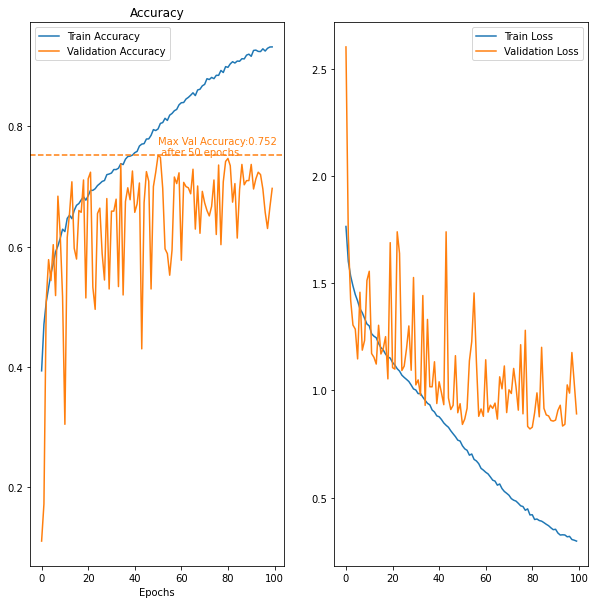

In [197]:
plot_history(derma_alexnet_history, 100)

Alexnet appears to produce accuracy scores similar to the benchmark performance identified by Yang et al., 2022. The model was run for 100 epochs
and it can be clearly seen that after 50 epochs the model's validation accuracy platues but the accuracy of the training set increases. This means the model tends to overfit the training data after 50 epochs.

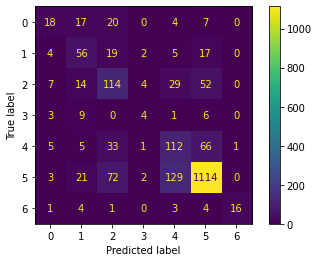

In [161]:
#plotting the confusion matrix for the DermaMnist test data
alexnet_derma_predictions = np.argmax(derma_alexnet.predict(alexnet_derma_test_images),axis=-1)
plot_confusion_matrix(derma_test_labels,alexnet_derma_predictions)

In [162]:
#plotting the classification report for the DermaMnist test data
print(classification_report(derma_test_labels, alexnet_derma_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.44      0.27      0.34        66
           1       0.44      0.54      0.49       103
           2       0.44      0.52      0.48       220
           3       0.31      0.17      0.22        23
           4       0.40      0.50      0.44       223
           5       0.88      0.83      0.85      1341
           6       0.94      0.55      0.70        29

    accuracy                           0.72      2005
   macro avg       0.55      0.48      0.50      2005
weighted avg       0.74      0.72      0.72      2005



As per the f1 Scores in the classification report, all class categories perform better than random chance especially class category 5 and 6.

In [163]:
derma_alexnet.evaluate(alexnet_derma_test_images,alexnet_derm_test_lab)

63/63 [==============================] - 0s 4ms/step - loss: 0.8719 - accuracy: 0.7152


[0.8719156384468079, 0.7152119874954224]

#VGG16 Network

VGG16 network is provided by the keras api with  weights trained on the imagnet dataset. The imagenet weights
were used as a starting point to further train the weights to classify the Retina and Derma datasets.

##VGG16 for RetinaMNIST Dataset

In [166]:
#The adopted Alexnet implementation requires images to be in 32x32 size
vgg_retina_train_images = keras.preprocessing.image.smart_resize(retina_train_images.copy(),(32, 32))
vgg_retina_test_images= keras.preprocessing.image.smart_resize(retina_test_images.copy(),(32, 32))
vgg_retina_val_images= keras.preprocessing.image.smart_resize(retina_val_images.copy(),(32, 32))
vgg_retina_train_images = vgg_retina_train_images/255
vgg_retina_test_images= vgg_retina_test_images/255
vgg_retina_val_images = vgg_retina_val_images/255

In [167]:
#Conversion of labels using to_categorical function
vgg_retina_train_lab = to_categorical(retina_train_labels.copy())
vgg_retina_val_lab = to_categorical(retina_val_labels.copy())
vgg_retina_test_lab = to_categorical(retina_test_labels.copy())

In [171]:
#data augmentation to increase size of training set and also facilitate generalization of model
vgg_retina_train_datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True
    )
vgg_retina_train_datagen.fit(vgg_retina_train_images)

vgg_retina_train_gen = vgg_retina_train_datagen.flow(vgg_retina_train_images, vgg_retina_train_lab, shuffle=False,batch_size=50)

In [172]:
#Initialising the vgg16 model
retina_vgg16 = create_vgg16(5)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [173]:
#Setting the optimiser and loss function for the model
optimizer_adam = Adam(learning_rate=0.0001)
retina_vgg16.compile(optimizer=optimizer_adam, loss=keras.metrics.categorical_crossentropy, metrics=['accuracy'])

In [174]:
#Training and validating the model with training and validation set
retina_vgg16_history = retina_vgg16.fit(x=vgg_retina_train_gen,epochs=100,validation_data=(vgg_retina_test_images, vgg_retina_test_lab),class_weight=class_weight_retina_dict)

Epoch 1/100
22/22 [==============================] - 6s 149ms/step - loss: 1.6602 - accuracy: 0.2241 - val_loss: 1.6154 - val_accuracy: 0.1050
Epoch 2/100
22/22 [==============================] - 2s 74ms/step - loss: 1.6019 - accuracy: 0.2287 - val_loss: 1.6898 - val_accuracy: 0.1100
Epoch 3/100
22/22 [==============================] - 2s 74ms/step - loss: 1.6083 - accuracy: 0.3685 - val_loss: 1.5958 - val_accuracy: 0.4350
Epoch 4/100
22/22 [==============================] - 2s 75ms/step - loss: 1.6099 - accuracy: 0.4500 - val_loss: 1.6005 - val_accuracy: 0.4350
Epoch 5/100
22/22 [==============================] - 2s 73ms/step - loss: 1.6097 - accuracy: 0.4500 - val_loss: 1.6022 - val_accuracy: 0.4350
Epoch 6/100
22/22 [==============================] - 2s 74ms/step - loss: 1.6099 - accuracy: 0.4500 - val_loss: 1.6015 - val_accuracy: 0.4350
Epoch 7/100
22/22 [==============================] - 2s 74ms/step - loss: 1.6096 - accuracy: 0.4500 - val_loss: 1.6035 - val_accuracy: 0.4350
Epoch

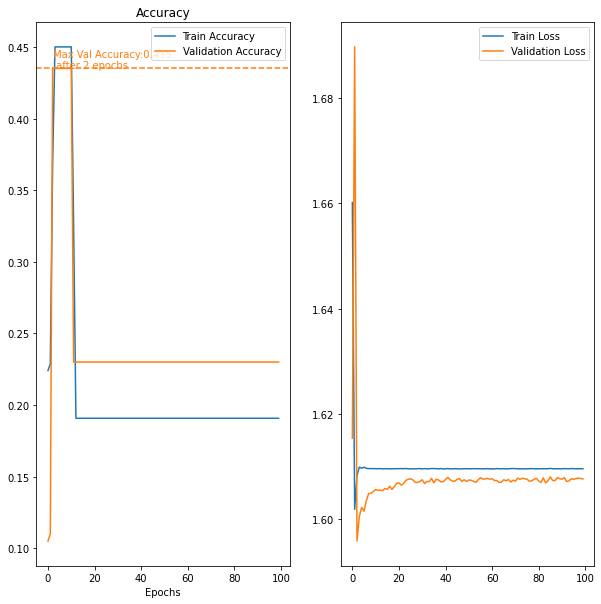

In [175]:
plot_history(retina_vgg16_history, 100)

VGG16 was trained for 100 epochs. Accuracy and validation accuracy trended upwards together for the first 11 epochs before they deviated.
beyond this point the model started to overfit on the training dataset.

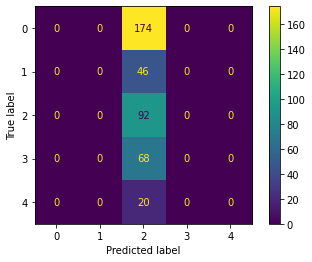

In [176]:
#plotting the confusion matrix for the DermaMnist test data
retina_vgg16_predictions = np.argmax(retina_vgg16.predict(vgg_retina_test_images),axis=-1)
plot_confusion_matrix(retina_test_labels,retina_vgg16_predictions)

In [177]:
#plotting the classification report for the DermaMnist test data
print(classification_report(retina_test_labels, retina_vgg16_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.00      0.00      0.00        46
           2       0.23      1.00      0.37        92
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00        20

    accuracy                           0.23       400
   macro avg       0.05      0.20      0.07       400
weighted avg       0.05      0.23      0.09       400



The VGG model was able to classify category '0' quite  well with the highest recorded f1 score while the other cateogries were classified 
 better than than random chance.

In [178]:
#Accuracy for test set
retina_vgg16.evaluate(vgg_retina_test_images,vgg_retina_test_lab)

13/13 [==============================] - 0s 12ms/step - loss: 1.6076 - accuracy: 0.2300


[1.6076256036758423, 0.23000000417232513]

##VGG16 For dermaMNIST

In [34]:
#The adopted VGG16 implementation requires images to be in 32x32 size
vgg_augmentated_derma_train_images = keras.preprocessing.image.smart_resize(oversampled_derma_train_images.copy(),(32, 32))
vgg_derma_test_images = keras.preprocessing.image.smart_resize(derma_test_images.copy(),(32, 32))
vgg_derma_val_images = keras.preprocessing.image.smart_resize(derma_val_images.copy(),(32, 32))
vgg_augmentated_derma_train_images = vgg_augmentated_derma_train_images/255
vgg_derma_test_images = vgg_derma_test_images/255
vgg_derma_val_images = vgg_derma_val_images/255

In [35]:
#Conversion of labels using to_categorical function
vgg_derm_train_lab = to_categorical(oversampled_derma_train_labels.copy())
vgg_derm_val_lab = to_categorical(derma_val_labels.copy())
vgg_derm_test_lab = to_categorical(derma_test_labels.copy())

In [36]:
#data augmentation to increase size of training set and also facilitate generalization of model
vgg_derm_train_datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True
    )
vgg_derm_train_datagen.fit(vgg_augmentated_derma_train_images)
vgg_derm_train_gen = vgg_derm_train_datagen.flow(vgg_augmentated_derma_train_images, vgg_derm_train_lab, shuffle=False,batch_size=25)

In [37]:
#Initializing the vgg16 model 
derma_vgg16 = create_vgg16(7)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [38]:
#Setting the optimiser and loss function for the model
optimizer_adam = Adam(learning_rate=0.001)
derma_vgg16.compile(optimizer=optimizer_adam, loss=keras.metrics.categorical_crossentropy, metrics=['accuracy'])

In [39]:
#Training and validating the model with training and validation set
derma_vgg_history = derma_vgg16.fit(x=vgg_derm_train_gen,epochs=30,steps_per_epoch=50,validation_data=(vgg_derma_val_images,vgg_derm_val_lab),class_weight=oversampled_class_weight_derma_dict)

Epoch 1/30
50/50 [==============================] - 12s 76ms/step - loss: 2.2500 - accuracy: 0.1504 - val_loss: 1.9240 - val_accuracy: 0.6690
Epoch 2/30
50/50 [==============================] - 3s 58ms/step - loss: 1.8970 - accuracy: 0.3944 - val_loss: 1.9224 - val_accuracy: 0.1097
Epoch 3/30
50/50 [==============================] - 3s 56ms/step - loss: 1.8283 - accuracy: 0.2856 - val_loss: 1.9167 - val_accuracy: 0.1097
Epoch 4/30
50/50 [==============================] - 3s 56ms/step - loss: 1.8752 - accuracy: 0.1960 - val_loss: 1.9182 - val_accuracy: 0.1107
Epoch 5/30
50/50 [==============================] - 3s 56ms/step - loss: 1.8345 - accuracy: 0.2144 - val_loss: 1.9074 - val_accuracy: 0.1107
Epoch 6/30
50/50 [==============================] - 3s 56ms/step - loss: 1.8736 - accuracy: 0.1984 - val_loss: 1.9151 - val_accuracy: 0.1107
Epoch 7/30
50/50 [==============================] - 3s 56ms/step - loss: 2.0291 - accuracy: 0.2224 - val_loss: 1.9355 - val_accuracy: 0.1107
Epoch 8/30
5

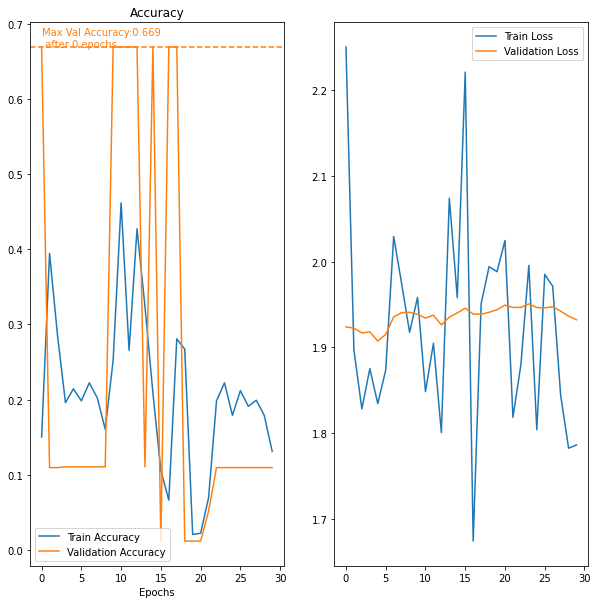

In [40]:
plot_history(derma_vgg_history, 30)

The VGG16 model was only trained for 30 epochs because the accuracies recorded were low. The accuracies mostly lingered below 0.3.
Therefore this model was abandoned from further training.

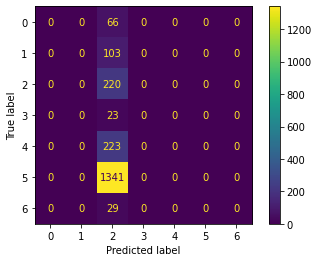

In [41]:
#plotting the confusion matrix for the DermaMnist test data
derma_vgg16_predictions = np.argmax(derma_vgg16.predict(vgg_derma_test_images),axis=-1)
plot_confusion_matrix(derma_test_labels,derma_vgg16_predictions)

In [42]:
#plotting the classification report for the DermaMnist test data
print(classification_report(derma_test_labels, derma_vgg16_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.00      0.00      0.00       103
           2       0.11      1.00      0.20       220
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00       223
           5       0.00      0.00      0.00      1341
           6       0.00      0.00      0.00        29

    accuracy                           0.11      2005
   macro avg       0.02      0.14      0.03      2005
weighted avg       0.01      0.11      0.02      2005



The model classified all images as category class '4' resulting in a recall of 1.

In [43]:
derma_vgg16.evaluate(vgg_derma_test_images,vgg_derm_test_lab)

63/63 [==============================] - 1s 12ms/step - loss: 1.9322 - accuracy: 0.1097


[1.9322152137756348, 0.10972568392753601]

# 7) Conclusions from ResNet50, AlexNet and Inception
**DermaMNIST:**

Amongst various Transfer learning models tried for Derma data, Alexnet was the only model which was able to predict all the labels. All other models tried we able to predict only one or two labels which could be due to class imbalance in training dataset or shortage of it. 




> **1) F1 Scores:** The best F1 scores were achieved by Alexnet model. Weighted average score was 0.67 and accuracy achieved was  74%. Although we have achieved more accuracy with ResNet50 model but it's F1 scores are too low.



> **2) Accuracy:** In terms of accuracy ResNet model looks to be performing the best but it is largely due to the class imbalance for class 0.



> **3) Graphs:** Looking at the accuracy and loss graphs for it appears that ResNet50 has got the best ft model but F1 scores and accuracy number do not suggest the same, this could again be attributed to the class imbalance of the train data.




**RetinaMNIST:**

For Retina dataset on the otherhand, ResNet50

was the best performing model. although it was not able to predict class 4 labels at all but it still was able to predict other labels fairly accurately. VGG16 model has similar numbers for Retina data as ResNet50 but the latter was better in predicting label 2 and 3 in comparison.



The accuracy scores are low in general for all models. Clearly in the images we can see that intra-class variance in data is higher than the inter class variance which is not ideal and this may be hampering prediction across models. 



> **1) F1 Scores:** Vgg16 model is best at predicting label 4 and marginally better than ResNet50 in predicting label 0 but when we compare weighted average for F1 scores ResNet50 was the best clearly due to it's ability to predict label 2 and 3 better. 



> **2) Accuracy:** The best accuracy was achieved with ResNet50 Model with consistent number close to 52%.



> **3) Graphs:** The accuracy and loss graphs for train and validation data show ResNet50 is the best fit model. The graphs show no overfitting and they the validation and train curves trend together on most occasions.

#References

Brownlee, J., 2022. Transfer Learning in Keras with Computer Vision Models. [online] Machine Learning Mastery. 
Available at: <https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/> [Accessed 9 March 2022].

Kumar, V., 2022. Hands-on Guide To Implementing AlexNet With Keras For Multi-Class Image Classification. [online] AIM. Available at: <https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/> [Accessed 8 March 2022].

Yang, J., Shi, R., Wei, D., Liu, Z., Zhao, L., Ke, B., Pfister, H. and Ni, B., 2022. MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification. [online] p.7. Available at: <https://arxiv.org/pdf/2110.14795.pdf> [Accessed 9 March 2022].